# Neural Network

In [1]:
# Packages used
import numpy as np
import matplotlib.pyplot as plt
from scipy import odr
from helper import *
import keras
from scipy.stats import norm
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Input
import keras.optimizers as opt
from keras.constraints import Constraint
from keras import backend as keras_backend
import tensorflow as tf
import time

In [57]:
def value_option_schwarz(T,M,K,path_matrix, r, realizations, order=2,option="call", poly_choice="laguerre"):
    '''
    Longstaff-Scharwz option pricer
    '''
    dt = T/M
    stopping_rule = np.zeros(path_matrix.shape)
    cash_flows = np.zeros(path_matrix.shape)
    
    # save payoffs for later use
    if option == "call":
        exercise_value = np.maximum(path_matrix-K,0)
        stopping_rule[:,-1] = np.where(path_matrix[:,-1]-K>0, 1, 0)
        cash_flows[:,-1] = np.maximum(path_matrix[:,-1]-K,0)
    else:
        exercise_value = np.maximum(K-path_matrix,0)
        stopping_rule[:,-1] = np.where(K-path_matrix[:,-1]>0, 1, 0)
        cash_flows[:,-1] = np.maximum(K-path_matrix[:,-1],0)
        
    exercise_value[:,0] = 0

    #for time in range(1,M-1):
    for time in range(0,M-1):
        # get X at time step and Y at time step+1 (Regress now) 
        if option == "call":
            X = np.where(path_matrix[:,M-time-1]>K, path_matrix[:,M-time-1], 0)
            Y = np.where(path_matrix[:,M-time-1]>K, cash_flows[:,M-time], 0)
        else:
            X = np.where(path_matrix[:,M-time-1]<K, path_matrix[:,M-time-1], 0)
            Y = np.where(path_matrix[:,M-time-1]<K, cash_flows[:,M-time], 0)
            
        X_nonzero = X[X>0]
        Y_nonzero = Y[X>0]
        Y_nonzero *= np.exp(-r * (T-time) * dt)
        #Y_nonzero -= -20
        
        
        if len(Y_nonzero!=0):
            # perform regression
            try:
                #print(f"In the money paths: {len(X_nonzero)}")
                poly = np.polynomial.laguerre.Laguerre.fit(X_nonzero, Y_nonzero, order)
            except:
                print("Regression failed. Inputs:")
                print(X_nonzero)
                print(Y_nonzero)
            final_y = poly(X_nonzero)
            
            ## Compare excerise with continuation
            ex_cont = np.zeros((len(X_nonzero), 2))

            if option == "call":
                ex_cont[:,0] = X_nonzero - K
            else:
                ex_cont[:,0] = K - X_nonzero
            ex_cont[:,1] = final_y
            
            j=0
            for i in range(len(X)):
                if X[i] > 0:
                    if ex_cont[j,0] > ex_cont[j,1]:
                        stopping_rule[i,:] = 0
                        stopping_rule[i,M-time-1] = 1
                        cash_flows[i, :] = 0
                        cash_flows[i, M-time-1] = ex_cont[j,0]
                    j+=1      
        else:
            print(f"time: {time}")
            print("No path in-the-money-path found. Convergence issues expected")
    
    return stopping_rule * exercise_value, cash_flows


In [43]:
def GBM_online(S_0, mu, sigma, T, dt, n):
    paths = []
    
    for i in range(n):
        prices = [S_0]
        time=0
        
        while(time+dt<=T):
            prices.append(prices[-1]*np.exp((mu-0.5*(sigma**2))*dt + sigma*np.random.normal(0, np.sqrt(dt))))
            time+=dt
        paths.append(prices)
    return paths

## Generate MC estimate of American

In [83]:
# Variables used
T = 1
M = 4
K = 110
S = 100
sigma = 0.2
r = 0.06
realizations = 10_000
delta = 0
dt = T/M
dates = np.flip(np.arange(0,M))

In [84]:
np.mean(s_all[:,-1])

105.20429943200416

In [85]:
# Define one simulation
trial_mean = []
trial_se = []

for jj in range(30):

    s_all = np.array(GBM_online(S,r, sigma, T, dt, realizations))
    [option_cash_flow, cash_flows] = value_option_schwarz(T,M,K,s_all, r, realizations, order=3, option="put")

    for time in range(option_cash_flow.shape[1]):
        option_cash_flow[:,time]*=np.exp(-r*(time*dt))

    data = np.zeros(realizations)
    data[0:len(option_cash_flow[option_cash_flow > 0])] = option_cash_flow[option_cash_flow > 0]

    trial_mean.append(np.mean(data))
    trial_se.append(np.std(data)/np.sqrt(realizations))

In [86]:
american_mean = np.mean(trial_mean)
american_se = np.mean(trial_se)

american_mean

11.11162404600949

In [87]:
american_se

0.07951611925342367

## Hyperparams

In [293]:
'''
Pricing options using Black-Scholes
'''

def d1(S0, r, delta, t0, t, k, sigma):
    return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))

def d2(S0, r, delta, t0, t, k, sigma):
    return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))

def BSMcall(S0, r, delta, t0, t, k, sigma):
    return S0*np.exp(-delta*(t-t0))*norm.cdf(d1(S0, r, delta, t0, t, k, sigma)) - k*np.exp(-r*(t-t0))*norm.cdf(d2(S0, r, delta, t0, t, k, sigma))

def BSMPut(S0, r, delta, t0, t, k, sigma):
    return k*np.exp(-r*(t-t0))*norm.cdf(-d2(S0, r, delta, t0, t, k, sigma)) - S0*np.exp(-delta*(t-t0))*norm.cdf(-d1(S0, r, delta, t0, t, k, sigma))

def fwdValue(S0, r, delta, t0, t, k):
    return S0*np.exp(-delta*(t-t0)) - k*np.exp(-r*(t-t0))

def depositPV(t0, t, p):
    return p*np.exp(-r*(t-t0))

'''
Price a portfolio
'''

def identify_positions(wt_list, strike_list):
    positions = np.where(np.logical_and(wt_list>0, strike_list<0), "C", 
                        np.where(np.logical_and(wt_list>0, strike_list>=0), "F", 
                                 np.where(np.logical_and(wt_list<0, strike_list>0), "P", "N")))
    
    pos = (np.array(np.unique(positions, return_counts=True)).T)
    no_of_pos_dict = {"C":0 , "P":0, "F":0 , "N":0 }
    
    for i in range(0, len(pos[:,0])):
        no_of_pos_dict[pos[i,0]] = int(pos[i,1])

    return no_of_pos_dict["C"], no_of_pos_dict["P"], no_of_pos_dict["F"], no_of_pos_dict["N"], positions

def find_instr_params(nn_strikes, inner_wts, outer_wts, outer_bias, positions, s_init):
    strikes_array = np.where(positions == "F", 
                            -1* np.divide(np.abs(nn_strikes), np.abs(inner_wts)), 
                            np.divide(np.abs(nn_strikes), np.abs(inner_wts)))
    deposit = outer_bias
    pfl_weights = np.multiply(np.abs(inner_wts), outer_wts)
    
    return strikes_array, deposit, pfl_weights

def static_hedge_value_nn(stock_vec, strike_list, positions, pfl_wts, deposit, 
                          s_init, r, delta, sigma, t, dt):
    strks = strike_list.reshape(1,-1)
    non_neg_strks = np.abs(strks)
    wts = pfl_wts.reshape(1,-1)
    pos = positions.reshape(1,-1)
    c_wt =   np.multiply(wts, np.where(pos=="C", 1, 0))
    p_wt =   np.multiply(wts, np.where(pos=="P", 1, 0))
    f_wt =   np.multiply(wts, np.where(pos=="F", 1, 0))
    
    stock_vec = stock_vec.reshape(-1,1)
    #nn_static_hedge_value = np.sum(c_wt*(np.maximum(stock_vec-non_neg_strks,0)) + 
    #                         p_wt*(np.maximum(non_neg_strks-stock_vec,0)) + 
    #                         f_wt*(stock_vec-strks), axis=1) + deposit
    
    portfolio_price_vec = np.sum(c_wt*BSMcall(stock_vec, r, delta, 0, dt, non_neg_strks, sigma) 
    + p_wt*BSMPut(stock_vec, r, delta, 0, dt, non_neg_strks, sigma) 
    + f_wt*fwdValue(stock_vec, r, delta, 0, dt, strks), axis=1) + (deposit * np.exp(-r*dt))
    
    pvt0_nn = np.sum(c_wt*BSMcall(s_init, r, delta, 0, dt, non_neg_strks, sigma) + 
                     p_wt*BSMPut(s_init, r, delta, 0, dt, non_neg_strks, sigma) + 
                     f_wt*fwdValue(s_init, r, delta, 0, dt, strks), axis=1) + (deposit * np.exp(-r*dt))
    
    return portfolio_price_vec, pvt0_nn

'''
A class that fits neural network to payoff paths of a Bermudan Option
'''

class neural_bermudan_fitter:
    def __init__(self, r, sigma, M, s_init, K, dates, option="put", ittol=10, T=1, nodes=10, epochs=10, 
                 pre_trained_model=None, s_all = None, delta=0, learning_rate=.001, N = 200):
        # strike price
        self.K=K
        # number of excercise opportunities. Assumed to be equidistant
        self.M=M
        # Time to maturity in years. Assumed to be an integer
        self.T=T
        # Time between each excersice date
        self.dt = self.T/self.M
        # Yearly risk free rate
        self.r = r
        # Volatility
        self.sigma = sigma
        # Initial asset price
        self.s_init = s_init
        # Amount of stock price path realizations
        self.N = N
        
        try: 
            _ = s_all.shape  
            self.stock_paths = s_all
            self.s_init_orig = 1
        except AttributeError:
            self.create_paths()
            
        self.dates = np.flip(np.arange(0,self.M))
        self.option = option.lower()
        self.M = len(self.dates)
        # only equidistant excersice dates are possible
        self.dt = self.T/self.M
        self.num_stoch_movements = len(self.stock_paths[0])
        self.nodes = nodes
        self.epochs = epochs
        self.ittol=ittol
        self.hedge = []
        
        self.evaluate_final()
        self.histories = []
        
        #step 3 of Jain
        self.nnets = []
        self.positions = []
        if pre_trained_model:
            self.nnets.append(pre_trained_model)
        else:
            self.learning_rate = learning_rate
            self.setup_network()
            
        
        self.V = np.zeros(self.N)
        self.Q_hat = np.zeros(self.N)
        self.callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
        self.opt_val = np.zeros((self.nodes, len(self.dates), self.N))
        self.delta=delta
        
        
    def create_paths(self):
        self.s_init_orig = self.s_init
        self.s_init = 1
        self.K = self.K/self.s_init_orig
        self.stock_paths = np.array(GBM_online(self.s_init,self.r, self.sigma, self.T, self.dt, self.N))
        
        
    def evaluate_final(self):
        # step 2 of algorithm in Jain paper
        if self.option == 'call':
            self.h = tf.maximum(self.stock_paths[:,-1] - self.K,0)
        else:
            self.h = tf.maximum(self.K - self.stock_paths[:,-1],0)
            
    def setup_network(self):
        nn = Sequential([
                    Input(shape=(1)),
                    Dense(self.nodes,activation='relu',trainable=True, kernel_initializer = 'random_uniform'),
                    Dense(1,activation='linear',trainable=True, kernel_initializer=keras.initializers.RandomUniform(minval=-0.01*self.s_init, maxval=0.01*self.s_init, seed=None), kernel_constraint = tf.keras.constraints.NonNeg())       
                    ])
        nn.compile(tf.optimizers.Adam(learning_rate=self.learning_rate), loss='mean_squared_error')
        
        if self.option=="call":
            Y_train = np.maximum(self.stock_paths[:,-1] - self.K, 0)
        else:
            Y_train = np.maximum(self.K - self.stock_paths[:,-1], 0)

        X_train = self.stock_paths[:,-1]
        
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
        history = nn.fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=self.epochs, verbose=0, callbacks=[callback])
        if history.history['loss'][-1] > 1:
            print("warning. NN didn't converge")
        
        self.nnets.append(nn)
        self.histories.append(history)
    
    def copy_network(self):
        new_model = keras.models.clone_model(self.nnets[-1])
        new_model.compile(tf.optimizers.Adam(learning_rate=self.learning_rate), loss='mean_squared_error')
        new_model.set_weights(self.nnets[-1].get_weights())
        self.nnets.append(new_model)
        
    def price_portfolio(self,m):
        inner_wts = np.array(self.nnets[-1].layers[0].get_weights()[0]).reshape(-1)
        nn_strikes_orig = np.array(self.nnets[-1].layers[0].get_weights()[1]).reshape(-1)
        outer_wts = np.array(self.nnets[-1].layers[1].get_weights()[0]).reshape(-1)
        outer_bias = np.array(self.nnets[-1].layers[1].get_weights()[1]).reshape(-1)
        
        #Genererate Derivative contract equivalents from weights
        #global no_of_calls, no_of_puts, no_of_fwds, nulls, positions, strike_arry, deposit, pfl_wts
        no_of_calls, no_of_puts, no_of_fwds, no_of_nulls, positions = identify_positions(inner_wts, nn_strikes_orig)
        self.positions.append(positions)
        strike_array, deposit, pfl_wts = find_instr_params(nn_strikes_orig, inner_wts, outer_wts, outer_bias, positions, self.s_init)
        deposit_list = np.array([deposit for i in range(0, self.nodes)])
        params = [strike_array.reshape(self.nodes,1), deposit_list.reshape(self.nodes,1), pfl_wts.reshape(self.nodes,1)]

        #Generate Hedge Values
        #stock_vec = np.array(df_sim_stocks_test.iloc[-1,:]).reshape(-1)
        self.Q_hat, self.pvt0_nn = static_hedge_value_nn(self.stock_paths[:,self.dates[m+1]], strike_array, positions, pfl_wts, deposit, 
                                                               self.s_init, self.r, self.delta, self.sigma, self.t, self.dt)
        
        self.hedge.append(params)
        self.pvt0_nn*=self.s_init_orig

        
        
    def run_pricing_simulation(self):  
        self.t=self.T
        # time to maturity for european options
        m=0
        for m in range(len(self.dates)-1):
            
            #step 5
            self.price_portfolio(m)
            
            self.copy_network()
            self.fit_model(m)
            self.t-=self.dt
        self.price_portfolio(m)
            
            
    def fit_model(self,m):
        Y_train = np.zeros(self.N)
        if self.option=='call':
            self.h = np.maximum(0, self.stock_paths[:,self.dates[m+1]] - self.K)
            for i, value in enumerate(self.h):
                if value > self.Q_hat[i]:
                    Y_train[i] = value
                else:
                    Y_train[i] = self.Q_hat[i]
            #print(Y_train)
        else:
            self.h = np.maximum(0, self.K - self.stock_paths[:,self.dates[m+1]])
            try:
                for i, value in enumerate(self.h):
                    if value > self.Q_hat[i]:
                        Y_train[i] = value
                    else:
                        Y_train[i] = self.Q_hat[i]
            except:
                print(self.h)
            #print(Y_train)
            
        X_train = np.array(self.stock_paths[:,self.dates[m+1]])
        self.histories.append(self.nnets[-1].fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=self.epochs, callbacks=[self.callback], verbose=0))
        i=0
        while self.histories[-1].history['loss'][-1] > 10 and i< self.ittol:
            i+=1
            print("warning. NN didn't converge")
            print(f"loss: {self.histories[-1].history['loss'][-1]}, time: {self.dates[m+1]}")
            self.histories.append(self.nnets[-1].fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=self.epochs, callbacks=[self.callback], verbose=0))



# Normalization versus non-normalization

In [294]:
nf = neural_bermudan_fitter(r, sigma, M, S, K, dates, learning_rate= 0.001, T=T, epochs = 1000, nodes = 12)
nf.run_pricing_simulation()

C:\Users\JWant\AppData\Local\Temp\ipykernel_3044\2013498954.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))
C:\Users\JWant\AppData\Local\Temp\ipykernel_3044\2013498954.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))


In [295]:
nf.pvt0_nn

array([0.12667701])

In [296]:
s_all = np.array(GBM_online(S,r, sigma, T, dt, 500))

In [297]:
nf = neural_bermudan_fitter(r, sigma, M, S, K, dates, learning_rate= 0.001, T=T, epochs = 1000, nodes = 12,
                           s_all = s_all, N = 500)
nf.run_pricing_simulation()
print(nf.pvt0_nn)

C:\Users\JWant\AppData\Local\Temp\ipykernel_3044\2013498954.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))
C:\Users\JWant\AppData\Local\Temp\ipykernel_3044\2013498954.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))


[0.12356892]


# Learning rate

In [98]:
lr_rate = [0.0001, 0.001, 0.01, 0.1]

In [644]:
nn_values=[]
nodes = 12

results_convergence = []

for lr in tqdm(lr_rate):
    # fit
    nf = neural_bermudan_fitter(r, sigma, M, S, K, dates, learning_rate=lr, T=T, epochs = 1000, nodes=nodes)
    # run simulation
    nf.run_pricing_simulation()
    
    # Save price
    results_convergence.append(nf.pvt0_nn)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\JWant\AppData\Local\Temp\ipykernel_17396\4083564787.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))
C:\Users\JWant\AppData\Local\Temp\ipykernel_17396\4083564787.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:47<00:00, 11.94s/it]


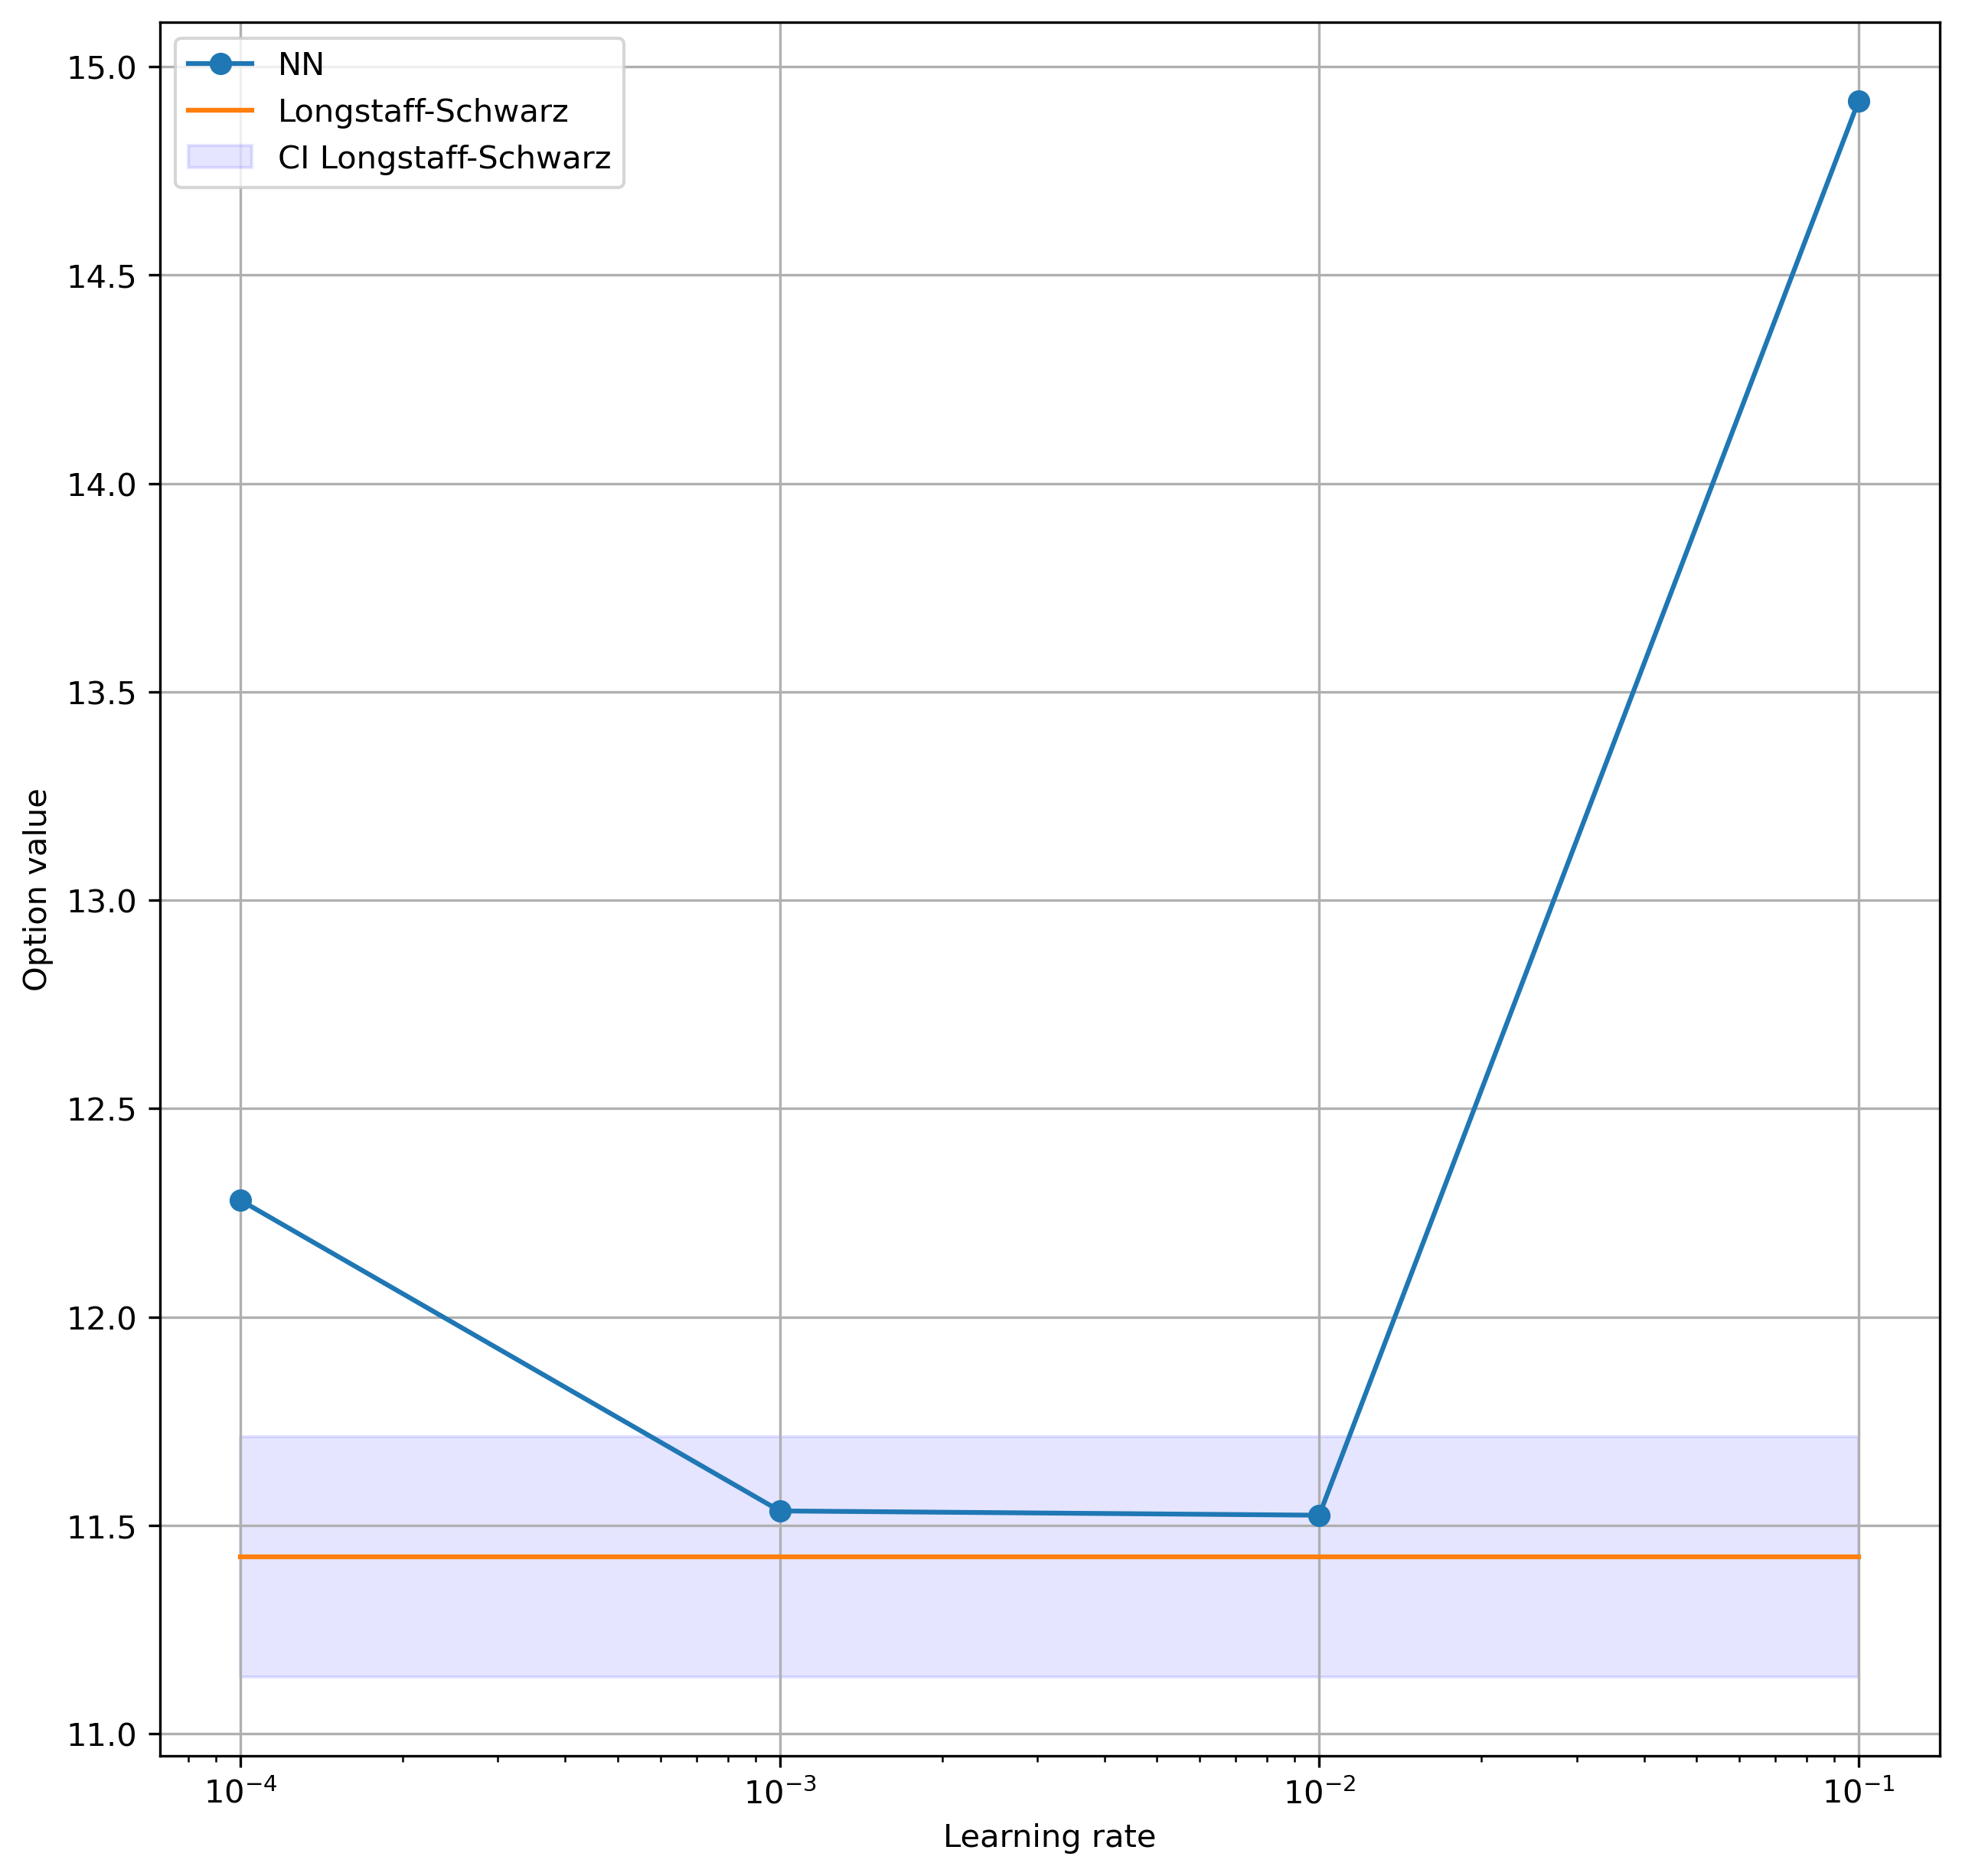

In [645]:
plt.figure(figsize = (10,10), dpi = 300)
plt.plot(lr_rate, results_convergence, label = 'NN', marker = 'o')
plt.plot(lr_rate, [american_mean] * len(lr_rate), label = 'Longstaff-Schwarz')
plt.fill_between(lr_rate, (american_mean - american_se), (american_mean + american_se), color = 'b', alpha = .1,
                label = 'CI Longstaff-Schwarz')

plt.legend()
plt.xlabel('Learning rate')
plt.ylabel('Option value')
plt.xscale('log')
plt.grid()
plt.savefig('figures/nn_learningrate.jpeg')
plt.show()

## Epochs

In [575]:
epochs_list = [10, 100, 1000, 10000, 30000]

In [646]:
#Study different # nodes
s_all = np.array([np.array(GBM_exact(T, S, sigma, r, M)) for x in range(realizations)])

results_convergence = []

for ep in tqdm(epochs_list):
    # fit
    nf = neural_bermudan_fitter(r, sigma, M, S, K, dates, learning_rate=0.001, T=T, epochs = ep, nodes=nodes)

    # run simulation
    nf.run_pricing_simulation()
    
    # Save price
    results_convergence.append(nf.pvt0_nn)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\JWant\AppData\Local\Temp\ipykernel_17396\4083564787.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))
C:\Users\JWant\AppData\Local\Temp\ipykernel_17396\4083564787.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.12s/it]


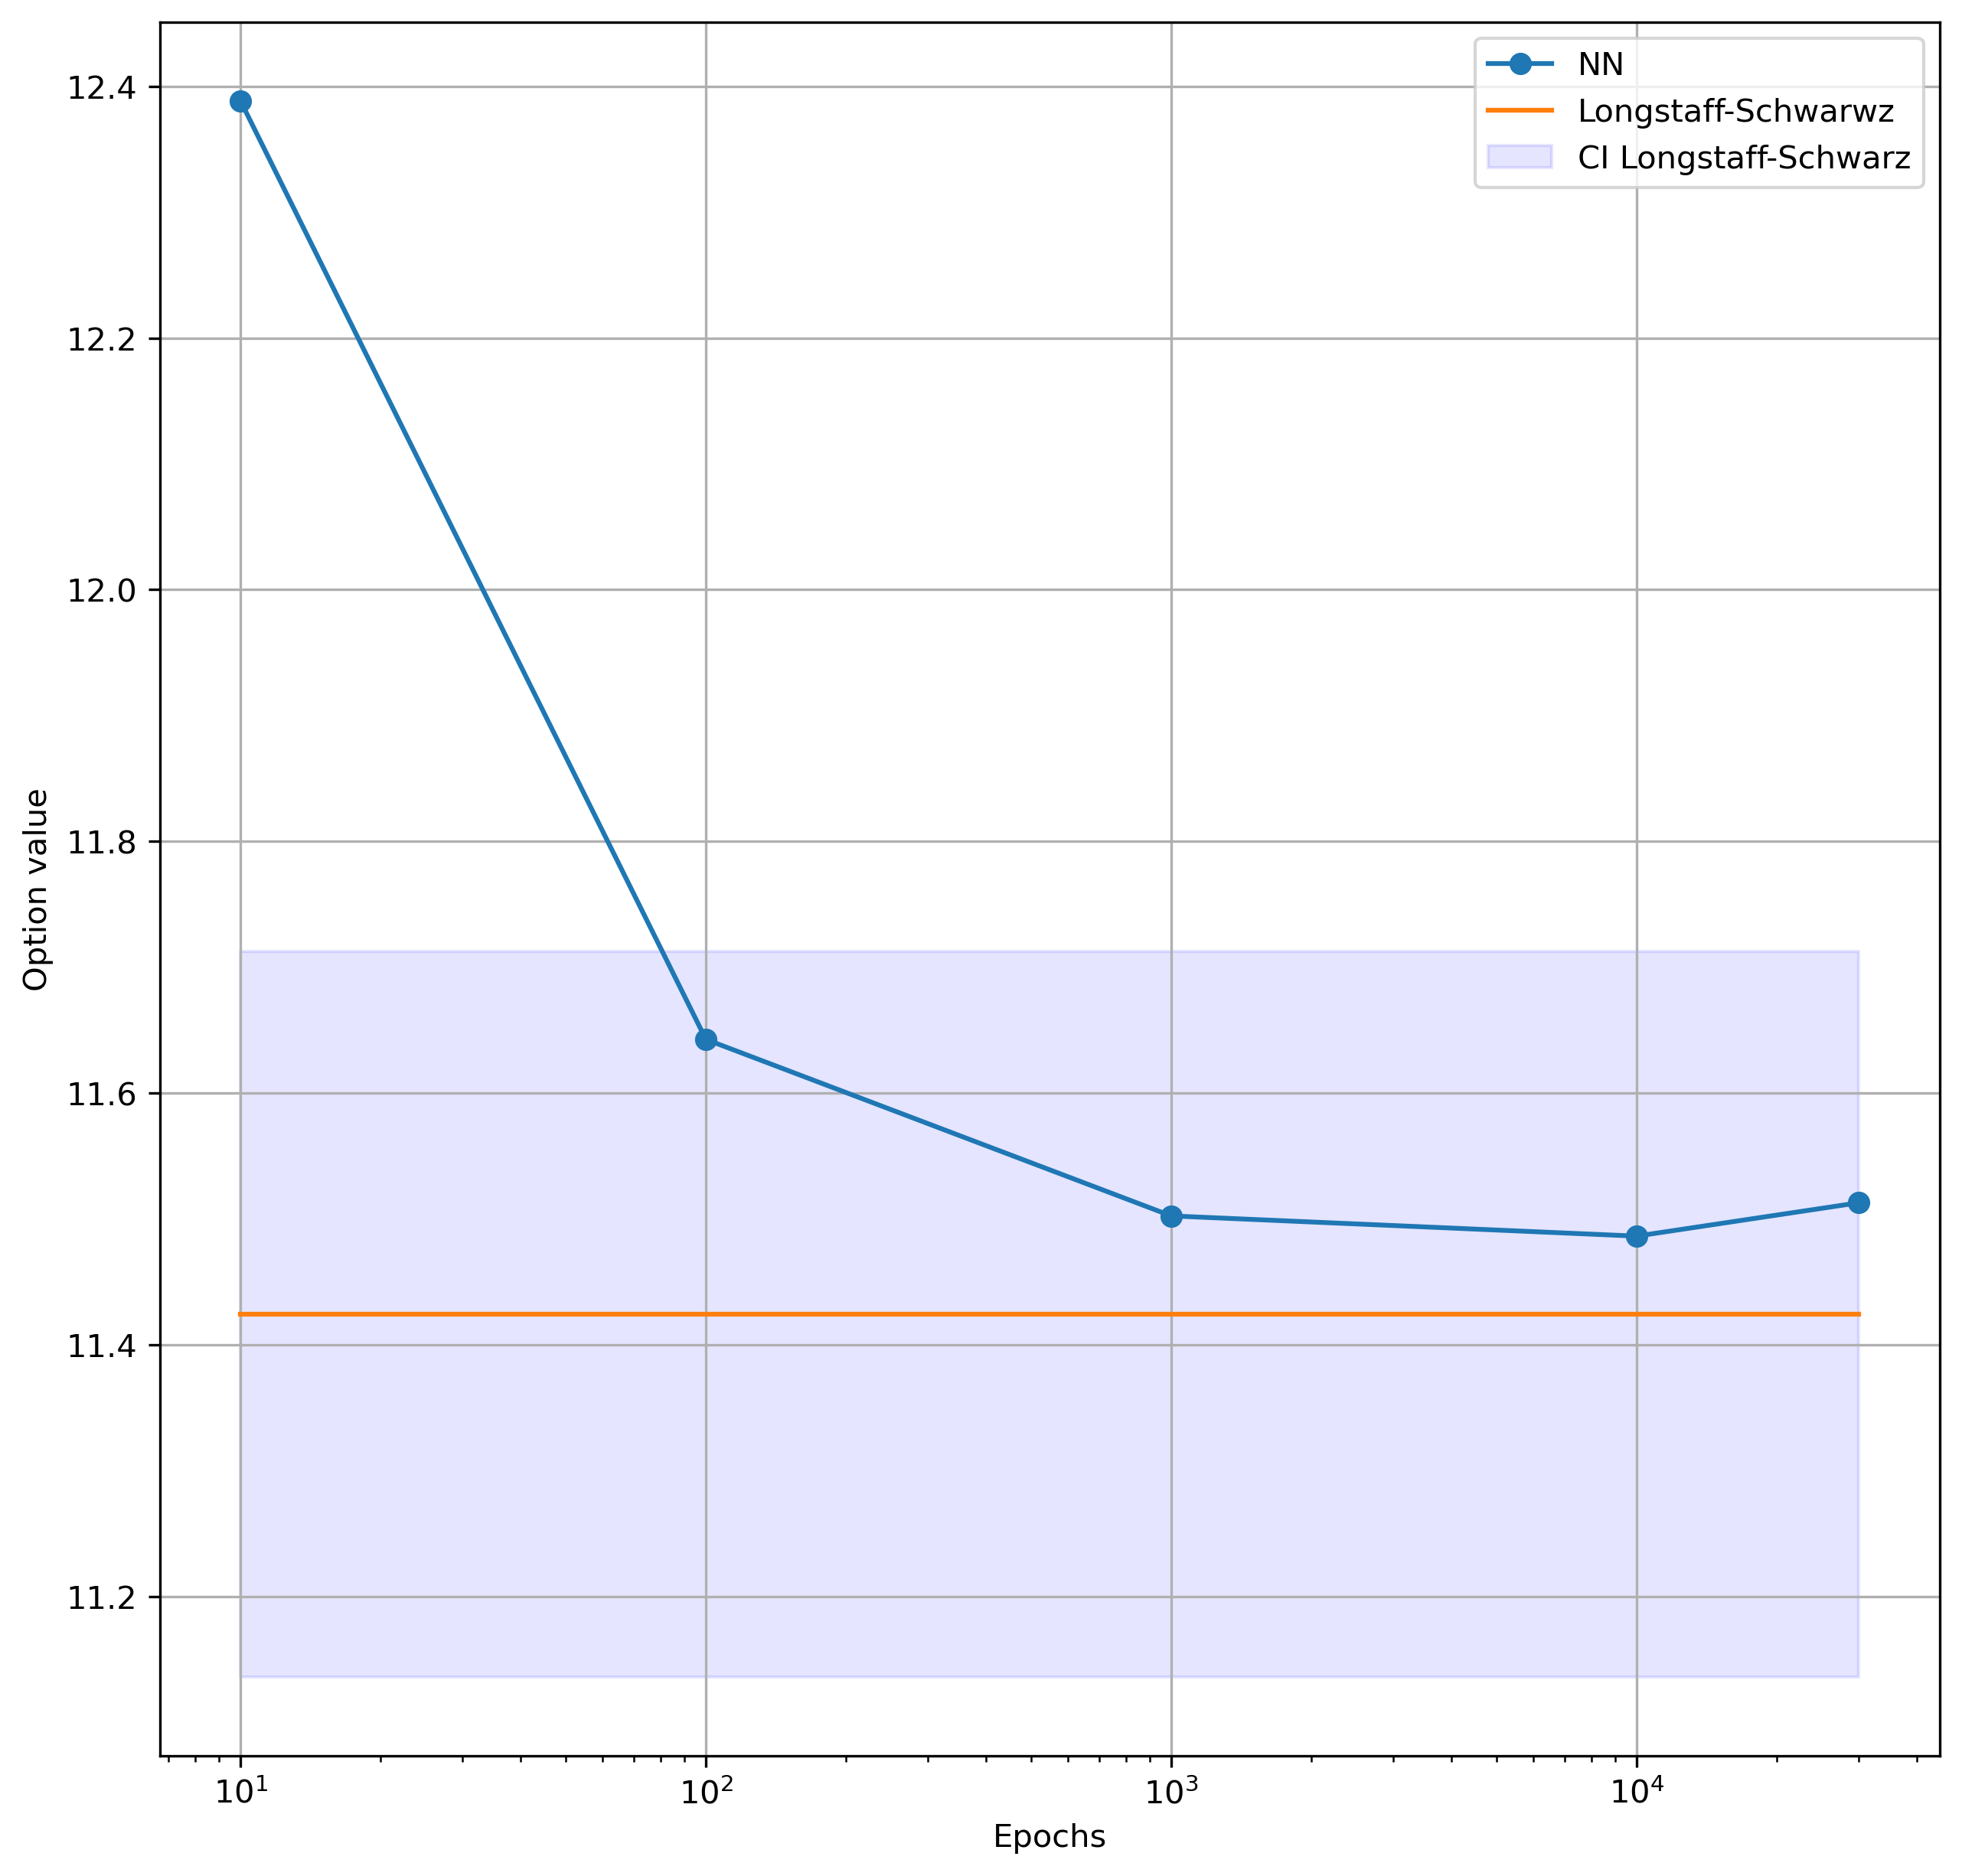

In [647]:
plt.figure(figsize = (10,10), dpi = 300)
plt.plot(epochs_list, results_convergence, label = 'NN', marker = 'o')
plt.plot(epochs_list, [american_mean] * len(epochs_list), label = 'Longstaff-Schwarwz')
plt.fill_between(epochs_list, (american_mean - american_se), (american_mean + american_se), color = 'b', alpha = .1,
                label = 'CI Longstaff-Schwarz')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Option value')
plt.xscale('log')
plt.grid()
plt.savefig('figures/nn_epochs.jpeg')
plt.show()

## Run on Grid

In [648]:
import time

trials = [10_000, 10, 100, 1000]
nodes = np.arange(1, 20)


ans = np.zeros((len(trials), len(nodes)))
times = np.zeros((len(trials), len(nodes)))

In [ ]:
nf = neural_bermudan_fitter(r, sigma, M, S, K, dates, learning_rate=lr, T=T, epochs = 1000, nodes=nodes)

In [ ]:
for i, trial in tqdm(enumerate(trials)):
    for j, node in enumerate(nodes):
        tic = time.time()
        
        nf = neural_bermudan_fitter(r, sigma, M, S, K, dates, learning_rate=lr, T=T, epochs = 1000, nodes=node, N=trial)
        nf.run_pricing_simulation()
        
        
        ans[i,j] = nf.pvt0_nn
        times[i,j] = time.time() - tic

0it [00:00, ?it/s]C:\Users\JWant\AppData\Local\Temp\ipykernel_17396\4083564787.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))
C:\Users\JWant\AppData\Local\Temp\ipykernel_17396\4083564787.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))


In [83]:
times_new = np.zeros(times.shape)
ans_new = np.zeros(ans.shape)

In [84]:
times_new[0,:] = times[1,:]
times_new[1,:] = times[2,:]
times_new[2,:] = times[3,:]
times_new[3,:] = times[0,:]

ans_new[0,:] = ans[1,:]
ans_new[1,:] = ans[2,:]
ans_new[2,:] = ans[3,:]
ans_new[3,:] = ans[0,:]

In [88]:
np.save("data/grid_values", ans_new)
np.save("data/grid_times", times_new)

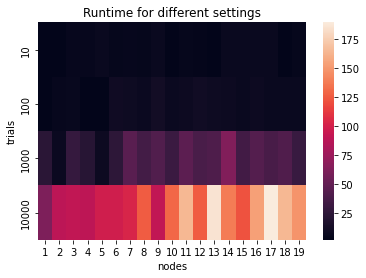

In [199]:
s= sns.heatmap(times_new, xticklabels=nodes, yticklabels=trials)
s.set_xlabel("nodes")
s.set_ylabel("trials")
s.set_title("Runtime for different settings")
s.figure.savefig("figures/runtime_heatmap.pdf", dpi=300)

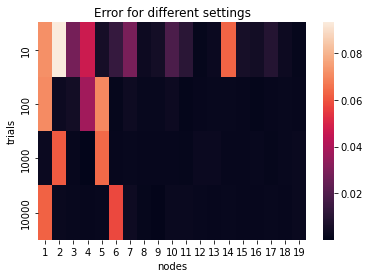

In [198]:
s=sns.heatmap(abs(ans_new-american_mean), xticklabels=nodes, yticklabels=trials)

s.set_xlabel("nodes")
s.set_ylabel("trials")
s.set_title("Error for different settings")
s.figure.savefig("figures/error_heatmap.pdf", dpi=300)

In [125]:
def normalize(data):
    return (data-np.mean(data))/np.std(data)

In [193]:
def make_measure(data):
    return (abs(data.min())+data)/(data.max()+abs(data.min()))

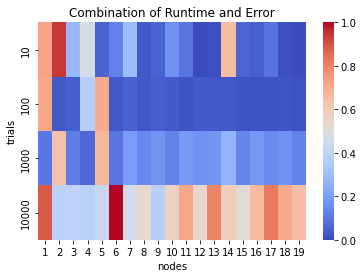

In [197]:
measure = make_measure(normalize(abs(ans_new-american_mean))+normalize(times_new))
s=sns.heatmap(measure,cmap="coolwarm", xticklabels=nodes, yticklabels=trials)

s.set_xlabel("nodes")
s.set_ylabel("trials")
s.set_title("Combination of Runtime and Error")
s.figure.savefig("figures/combination_heatmap.pdf", dpi=300)

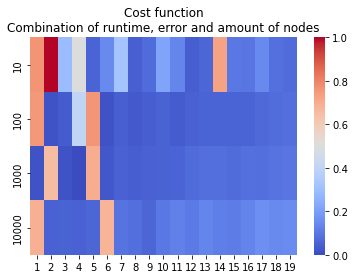

In [195]:
measure = make_measure(normalize(abs(ans_new-american_mean))*10+normalize(times_new)+normalize(nodes))
ax=plt.axes()
sns.heatmap(measure,cmap="coolwarm", xticklabels=nodes, yticklabels=trials, ax=ax)
ax.set_title("Cost function\nCombination of runtime, error and amount of nodes")
plt.show()

## Convergence based on number of MC trials

In [20]:
# Variables used
T = M = N = 4
K = 1.1
S = 1
sigma = 0.2
r = 0.06
#realizations = 2000
delta = 0
t = 1
dt = T/M

In [21]:
#trials = [10, 100, 1000, 10_000]
#trials = [100, 1000]
s_trials = []

for trial in trials:
    s_trials.append(np.array([np.array(GBM_exact(T, S, sigma, r, M)) for x in range(trial)]))

In [22]:
results_convergence = []

for s_trial in tqdm(s_trials):

    s_all = s_trial
    
    # Set up neural network
    nn = Sequential([
            Input(shape=(1)),
            Dense(10,activation='relu',trainable=True, kernel_initializer = 'random_uniform'),
            Dense(1,activation='linear',trainable=True, kernel_initializer=keras.initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=None))
            ])
    nn.compile(tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    
    # Train die nn
    Y_train = np.maximum(K - s_all[:,-1], 0)
    X_train = s_all[:,-1]

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
    history = nn.fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=500, verbose=0, callbacks=[callback])
    if history.history['loss'][-1] > 1:
        print("warning. NN didn't converge")

    dates = [3,2,1,0]

    # fit
    nf = neural_bermudan_fitter(r, sigma, s_all,  K, dates, epochs = 1000, nodes= 10)

    # run simulation
    nf.run_pricing_simulation()
    
    # Save price
    results_convergence.append(nf.pvt0_nn)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\sebas\AppData\Local\Temp/ipykernel_8752/3018685175.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))
C:\Users\sebas\AppData\Local\Temp/ipykernel_8752/3018685175.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:38<00:00, 24.52s/it]


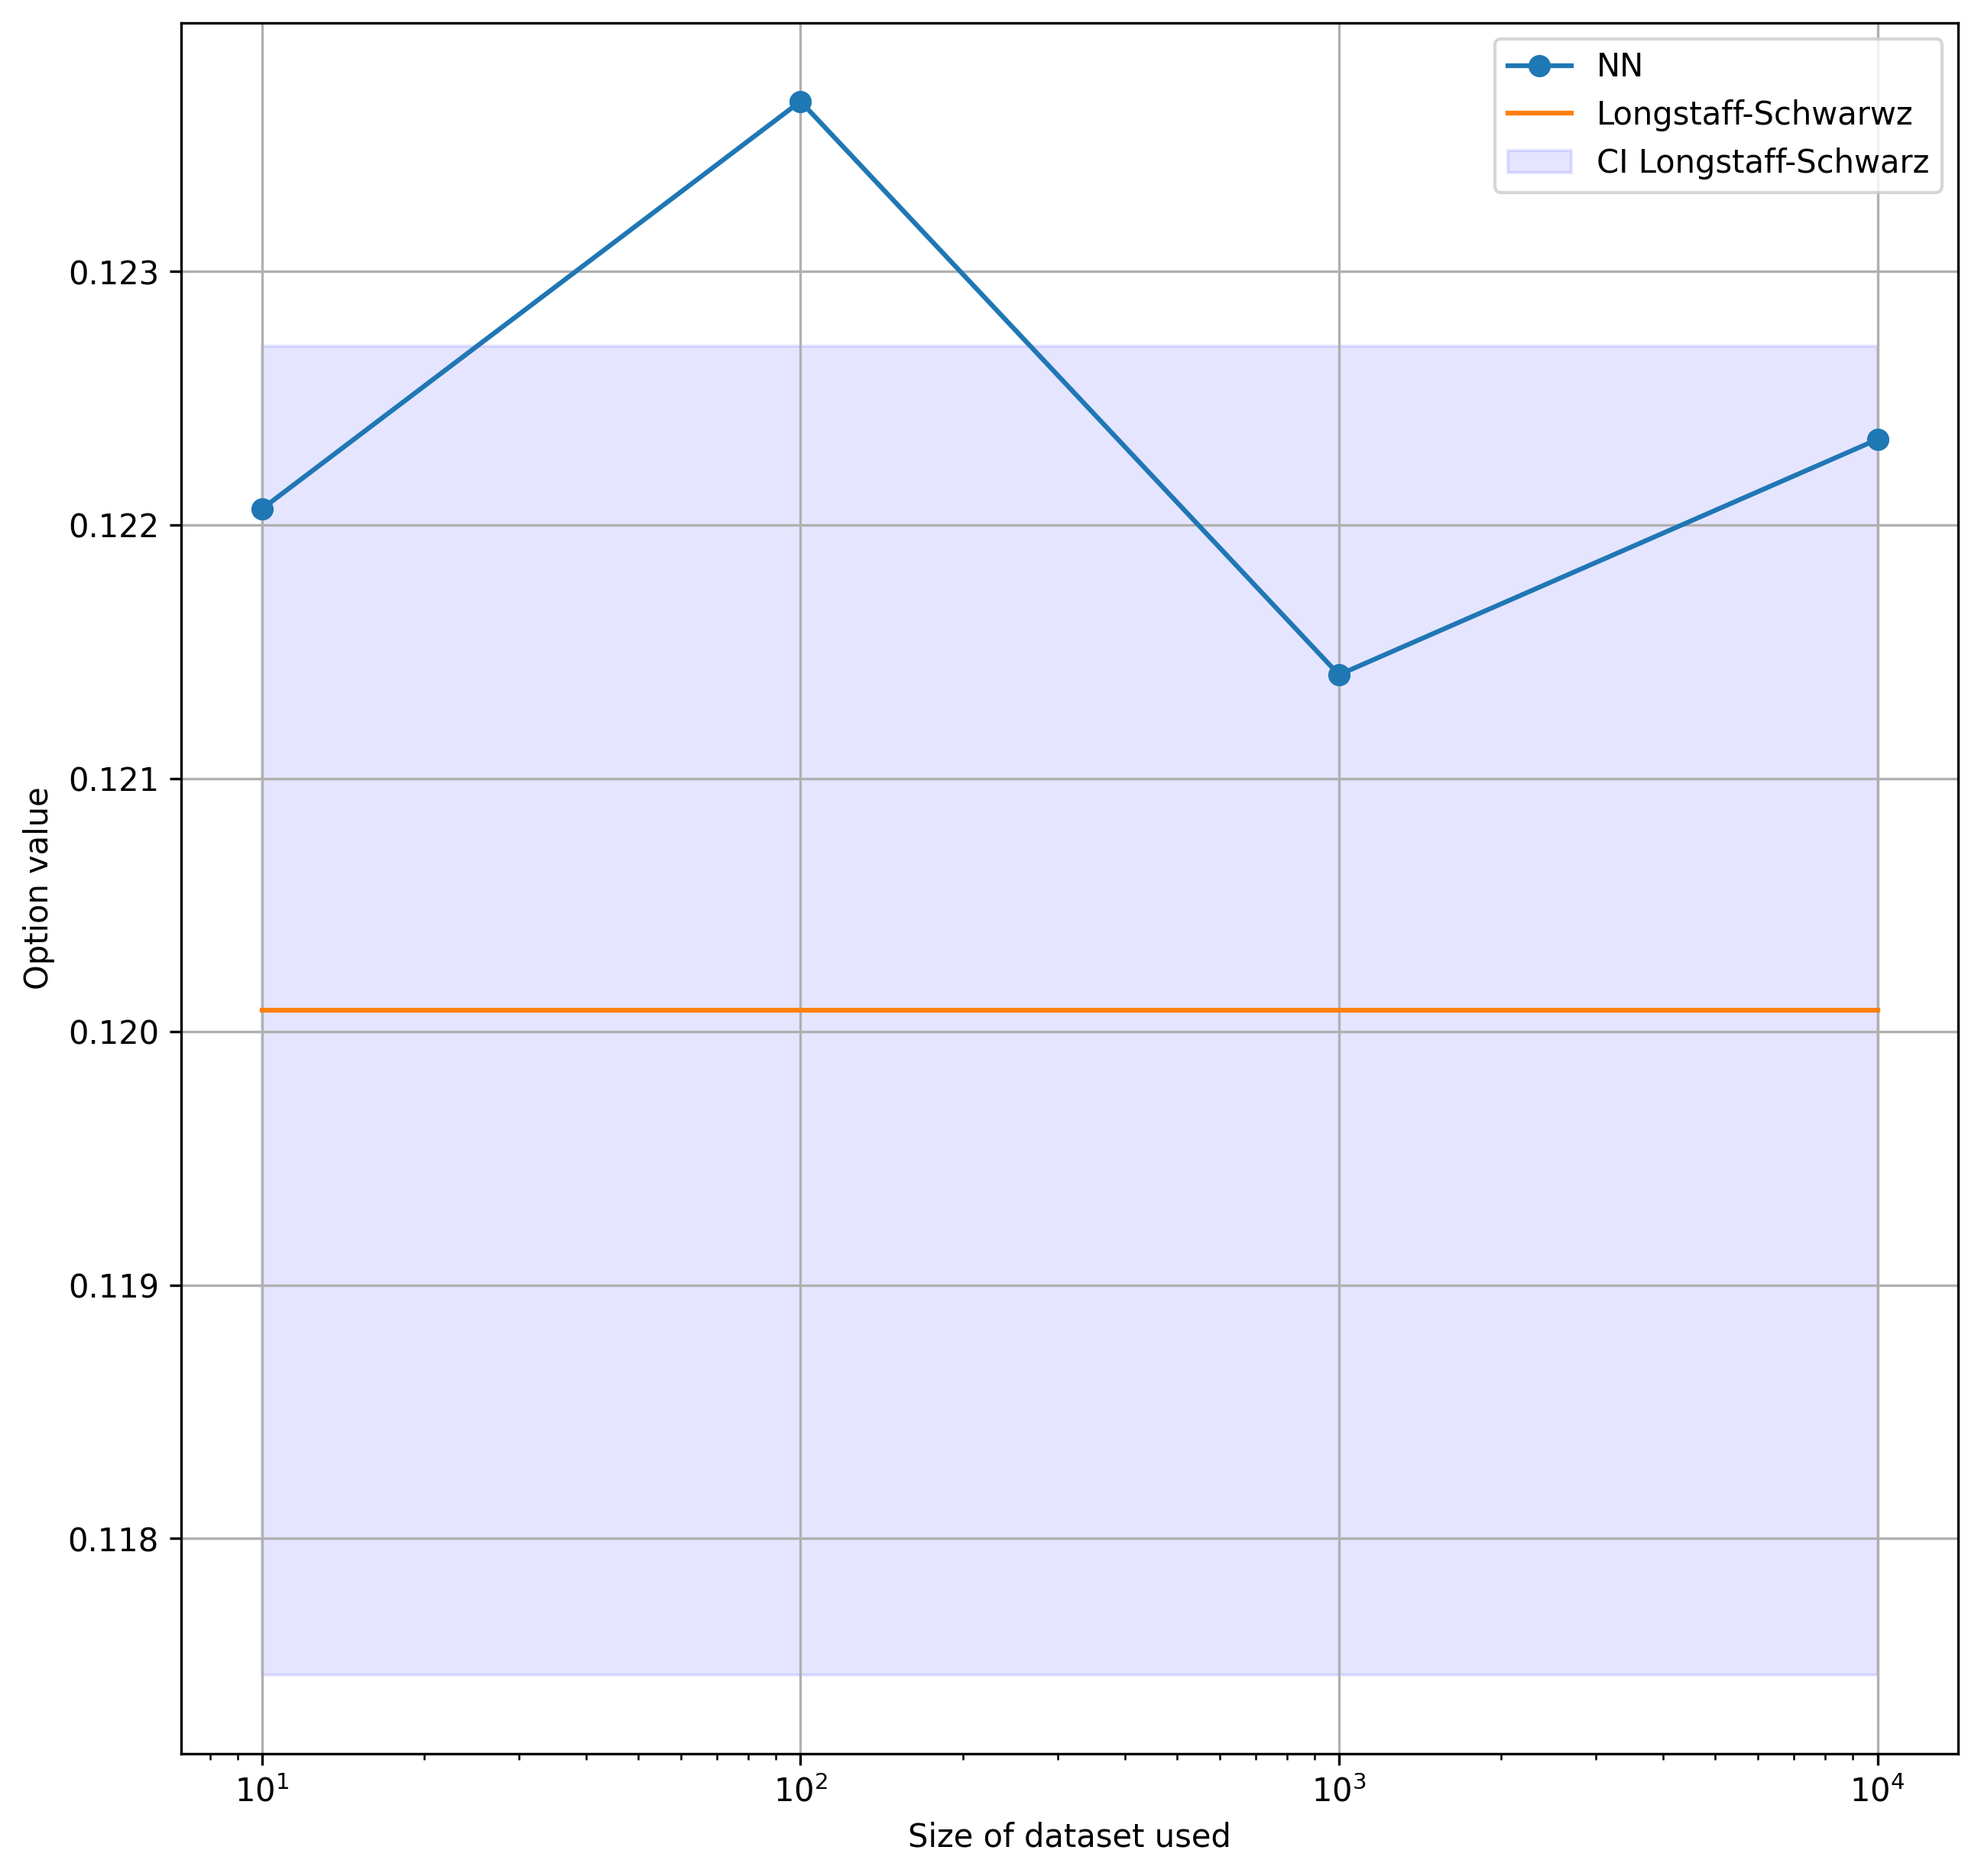

In [23]:
plt.figure(figsize = (10,10), dpi = 300)
plt.plot(trials, results_convergence, label = 'NN', marker = 'o')
plt.plot(trials, [american_mean] * len(trials), label = 'Longstaff-Schwarwz')
plt.fill_between(trials, (american_mean - american_se), (american_mean + american_se), color = 'b', alpha = .1,
                label = 'CI Longstaff-Schwarz')

plt.legend()
plt.xlabel('Size of dataset used')
plt.ylabel('Option value')
plt.xscale('log')
plt.grid()
#plt.savefig('figures/nn_dataset.jpeg')
plt.show()

## Convergence as number of nodes increases

In [13]:
# Variables used
T = M = N = 4
K = 1.1
S = 1
sigma = 0.2
r = 0.06
realizations = 2000

In [14]:
#Study different # nodes
S=1
K=1.1
Nnodes = np.arange(1, 20)
nn_values=[]
s_init=S
delta=0
t=1
realizations = 100
T = 1

s_all = np.array([np.array(GBM_exact(T, S, sigma, r, M)) for x in range(realizations)])

results_convergence = []

for nodes in tqdm(Nnodes):

    nodes = int(nodes)
    # Set up neural network
    nn = Sequential([
            Input(shape=(1)),
            Dense(nodes,activation='relu',trainable=True, kernel_initializer = 'random_uniform'),
            Dense(1,activation='linear',trainable=True, kernel_initializer=keras.initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=None))
            ])
    nn.compile(tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    
    # Train die nn
    Y_train = np.maximum(K - s_all[:,-1], 0)
    X_train = s_all[:,-1]

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
    history = nn.fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=500, verbose=0, callbacks=[callback])
    if history.history['loss'][-1] > 1:
        print("warning. NN didn't converge")

    dates = [3,2,1,0]

    # fit
    nf = neural_bermudan_fitter(r, sigma, s_all,  K, dates, epochs = 1000, nodes=nodes)

    # run simulation
    nf.run_pricing_simulation()
    
    # Save price
    results_convergence.append(nf.pvt0_nn)

  0%|                                                                                           | 0/19 [00:00<?, ?it/s]C:\Users\sebas\AppData\Local\Temp/ipykernel_17096/98645413.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))
C:\Users\sebas\AppData\Local\Temp/ipykernel_17096/98645413.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))
100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [01:43<00:00,  5.47s/it]


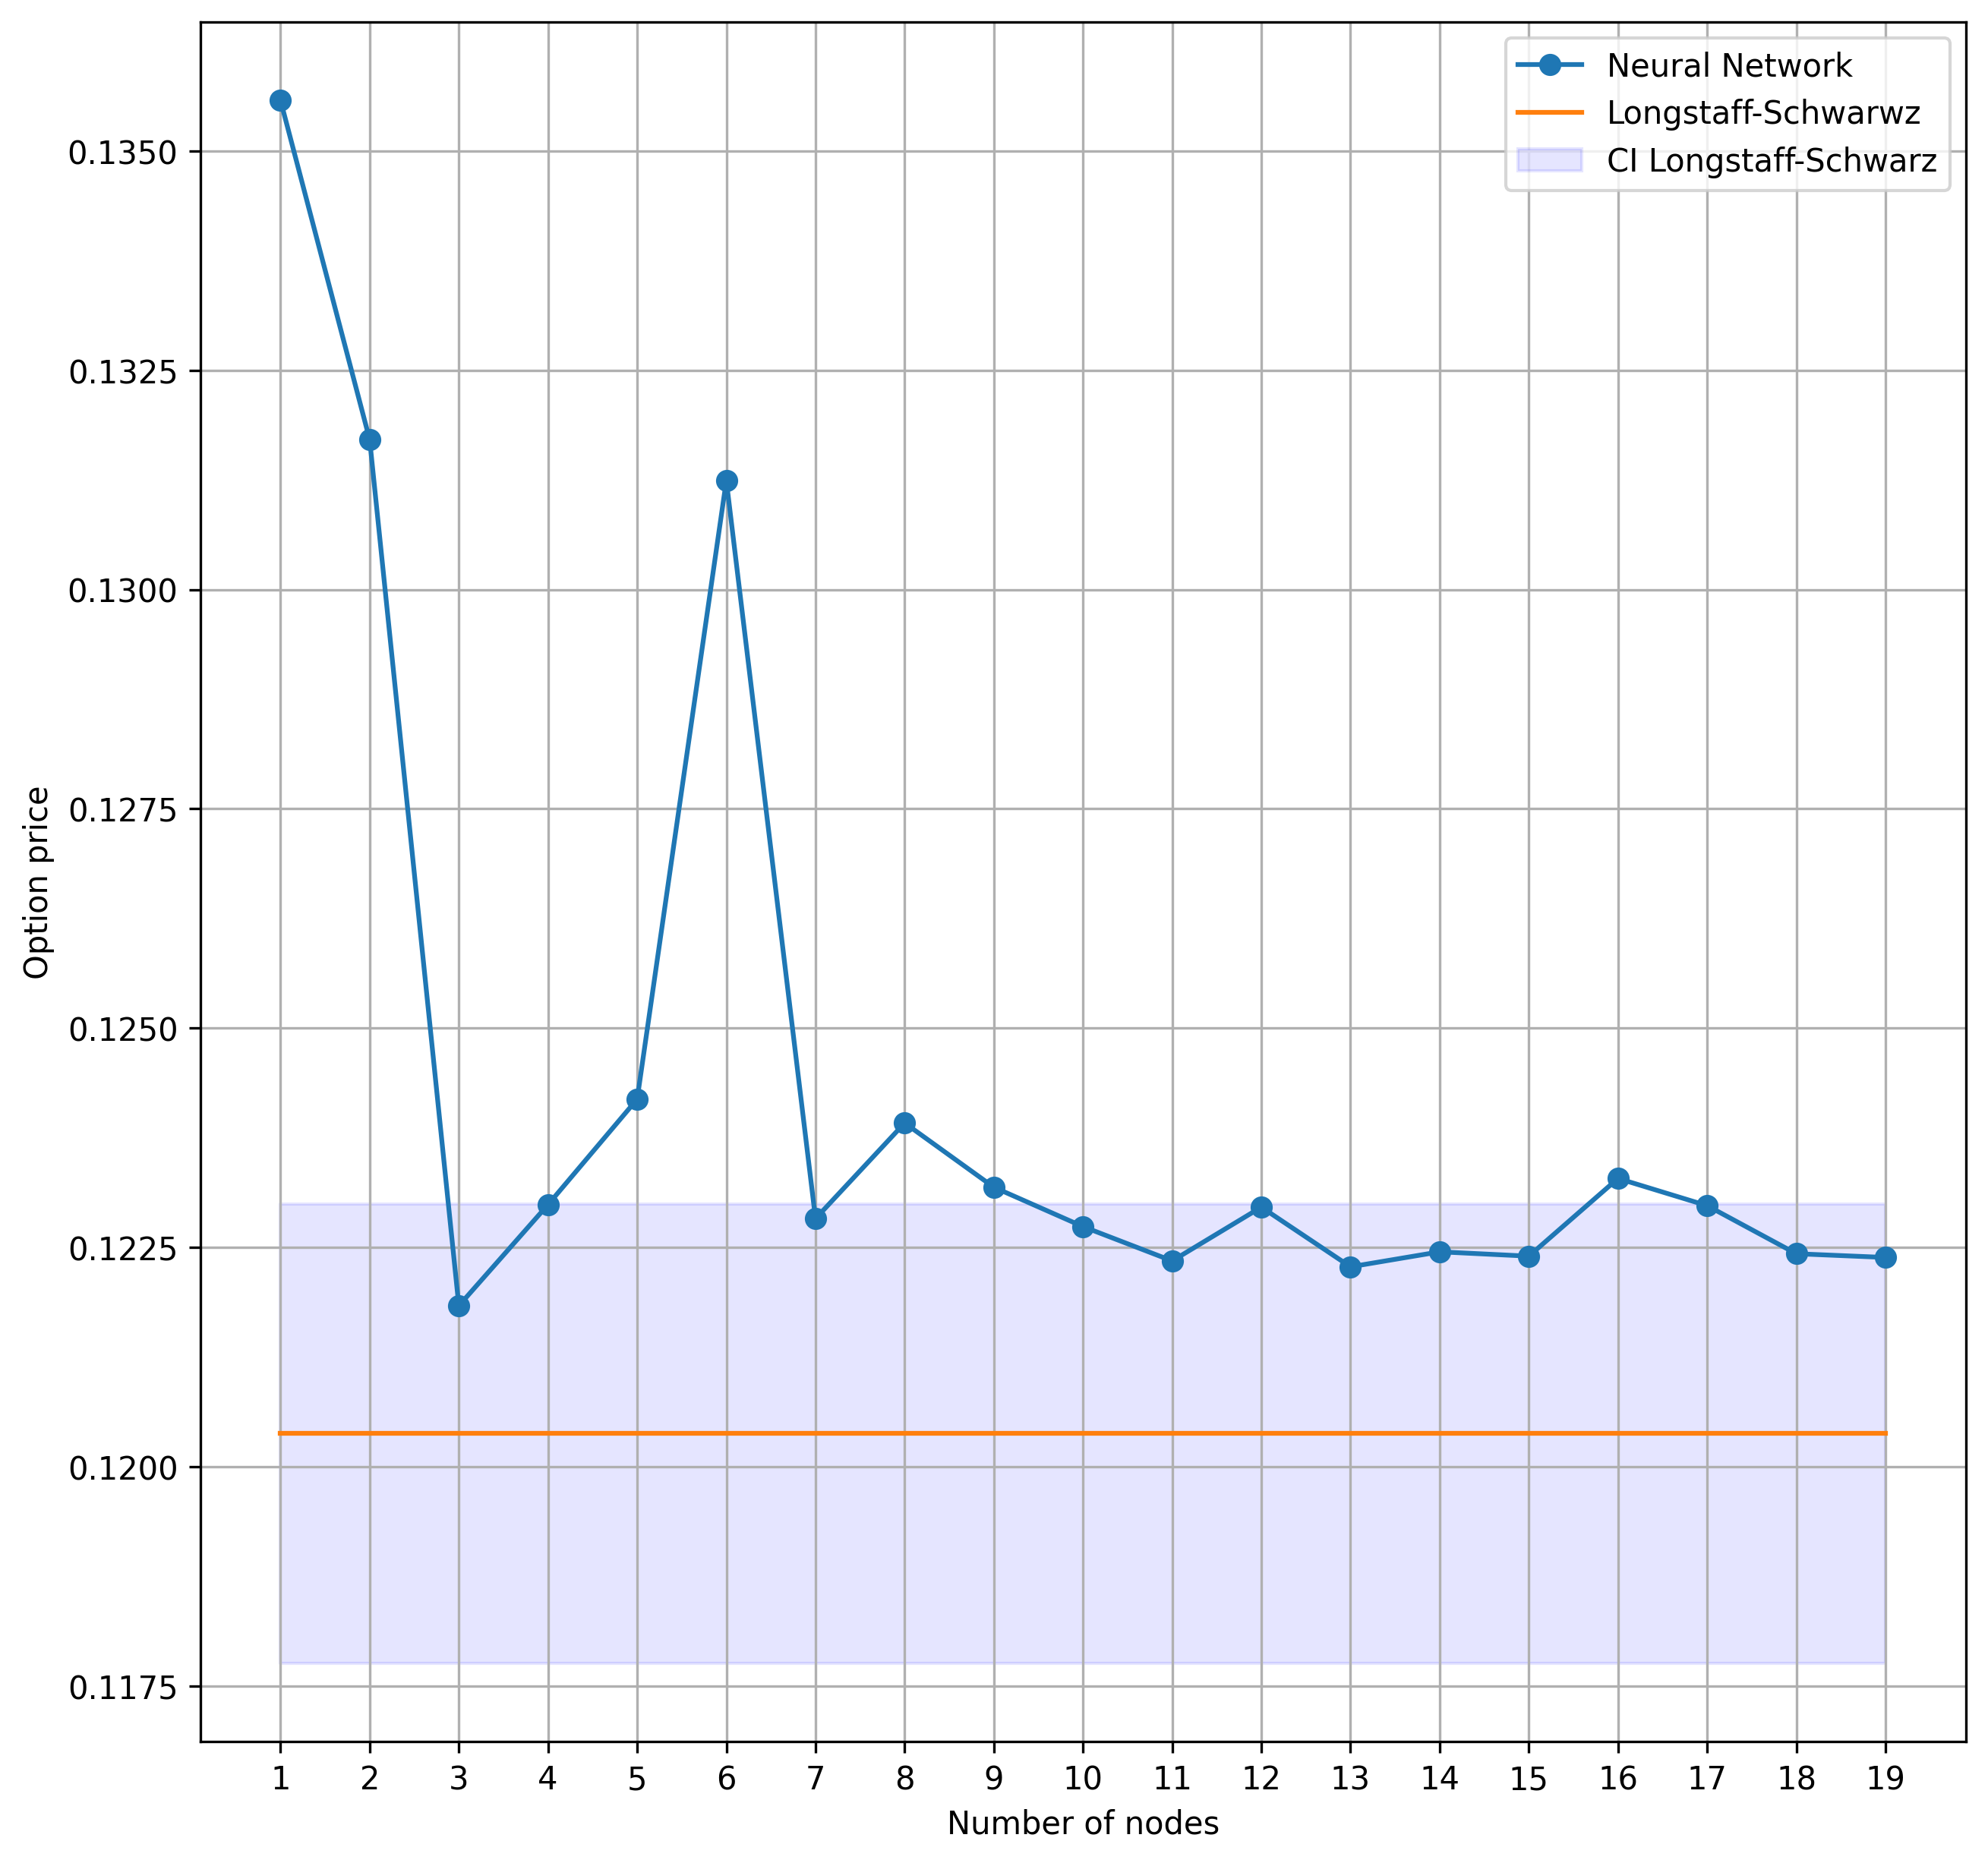

In [16]:
plt.figure(figsize = (10, 10), dpi = 300)
plt.plot(Nnodes, results_convergence, marker = 'o', label = 'Neural Network')
plt.plot(Nnodes, [american_mean] * len(Nnodes), label = 'Longstaff-Schwarwz')
plt.fill_between(Nnodes, (american_mean - american_se), (american_mean + american_se), color = 'b', alpha = .1,
                label = 'CI Longstaff-Schwarz')

plt.grid()
plt.xlabel('Number of nodes')
plt.xticks(Nnodes)
plt.ylabel('Option price')
plt.legend()
plt.savefig('figures/nn_nodes.jpeg')
plt.show()

## Various Black Scholes Params

In [17]:
# Standard variables
T = M = N = 4
K = 1.1
S = 1
sigma = 0.2
r = 0.06
realizations = 2000
delta = 0
t = 1
dt = T / M
nodes = 10


# Arrays to be loop
Rs = [0.03, 0.06, 0.09, 0.12, 0.15]
sigmas = [0.05, 0.1, 0.2, 0.3]
Ks = [0.9, 1, 1.1, 1.2]

In [18]:
'''Varying R'''

results_convergence_R = []

for int_rate in tqdm(Rs):

    s_all = np.array([np.array(GBM_exact(T, S, sigma, int_rate, M)) for x in range(realizations)])
    
    # Set up neural network
    nn = Sequential([
            Input(shape=(1)),
            Dense(nodes, activation='relu',trainable=True, kernel_initializer = 'random_uniform'),
            Dense(1,activation='linear',trainable=True, kernel_initializer=keras.initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=None))
            ])
    nn.compile(tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    
    # Train die nn
    Y_train = np.maximum(K - s_all[:,-1], 0)
    X_train = s_all[:,-1]

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
    history = nn.fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=500, verbose=0, callbacks=[callback])
    if history.history['loss'][-1] > 1:
        print("warning. NN didn't converge")

    dates = [3,2,1,0]

    # fit
    nf = neural_bermudan_fitter(int_rate, sigma, s_all,  K, dates, epochs = 1000, nodes = nodes)

    # run simulation
    nf.run_pricing_simulation()
    
    # Save price
    results_convergence_R.append(nf.pvt0_nn)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\sebas\AppData\Local\Temp/ipykernel_17096/98645413.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))
C:\Users\sebas\AppData\Local\Temp/ipykernel_17096/98645413.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:10<00:00, 26.04s/it]


In [19]:
'''  asdf'''

trial_mean_dict = []
trial_se_dict = []

for int_rate in tqdm(Rs):
    trial_mean = []
    trial_se = []
    
    for jj in range(30):

        s_all = np.array([np.array(GBM_exact(T, S, sigma, int_rate, M)) for x in range(realizations)])
        [option_cash_flow, cash_flows] = value_option_schwarz(T,M,K,s_all, int_rate, realizations, order=2, option="put")

        for time in range(option_cash_flow.shape[1]):
            option_cash_flow[:,time]*=np.exp(-int_rate*(time*dt))

        data = np.zeros(realizations)
        data[0:len(option_cash_flow[option_cash_flow > 0])] = option_cash_flow[option_cash_flow > 0]

        trial_mean.append(np.mean(data))
        trial_se.append(np.std(data)/np.sqrt(realizations))
    
    trial_mean_dict.append(np.mean(trial_mean))
    trial_se_dict.append(np.mean(trial_se))
    
trial_mean_dict = np.array(trial_mean_dict)
trial_se_dict = np.array(trial_se_dict)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


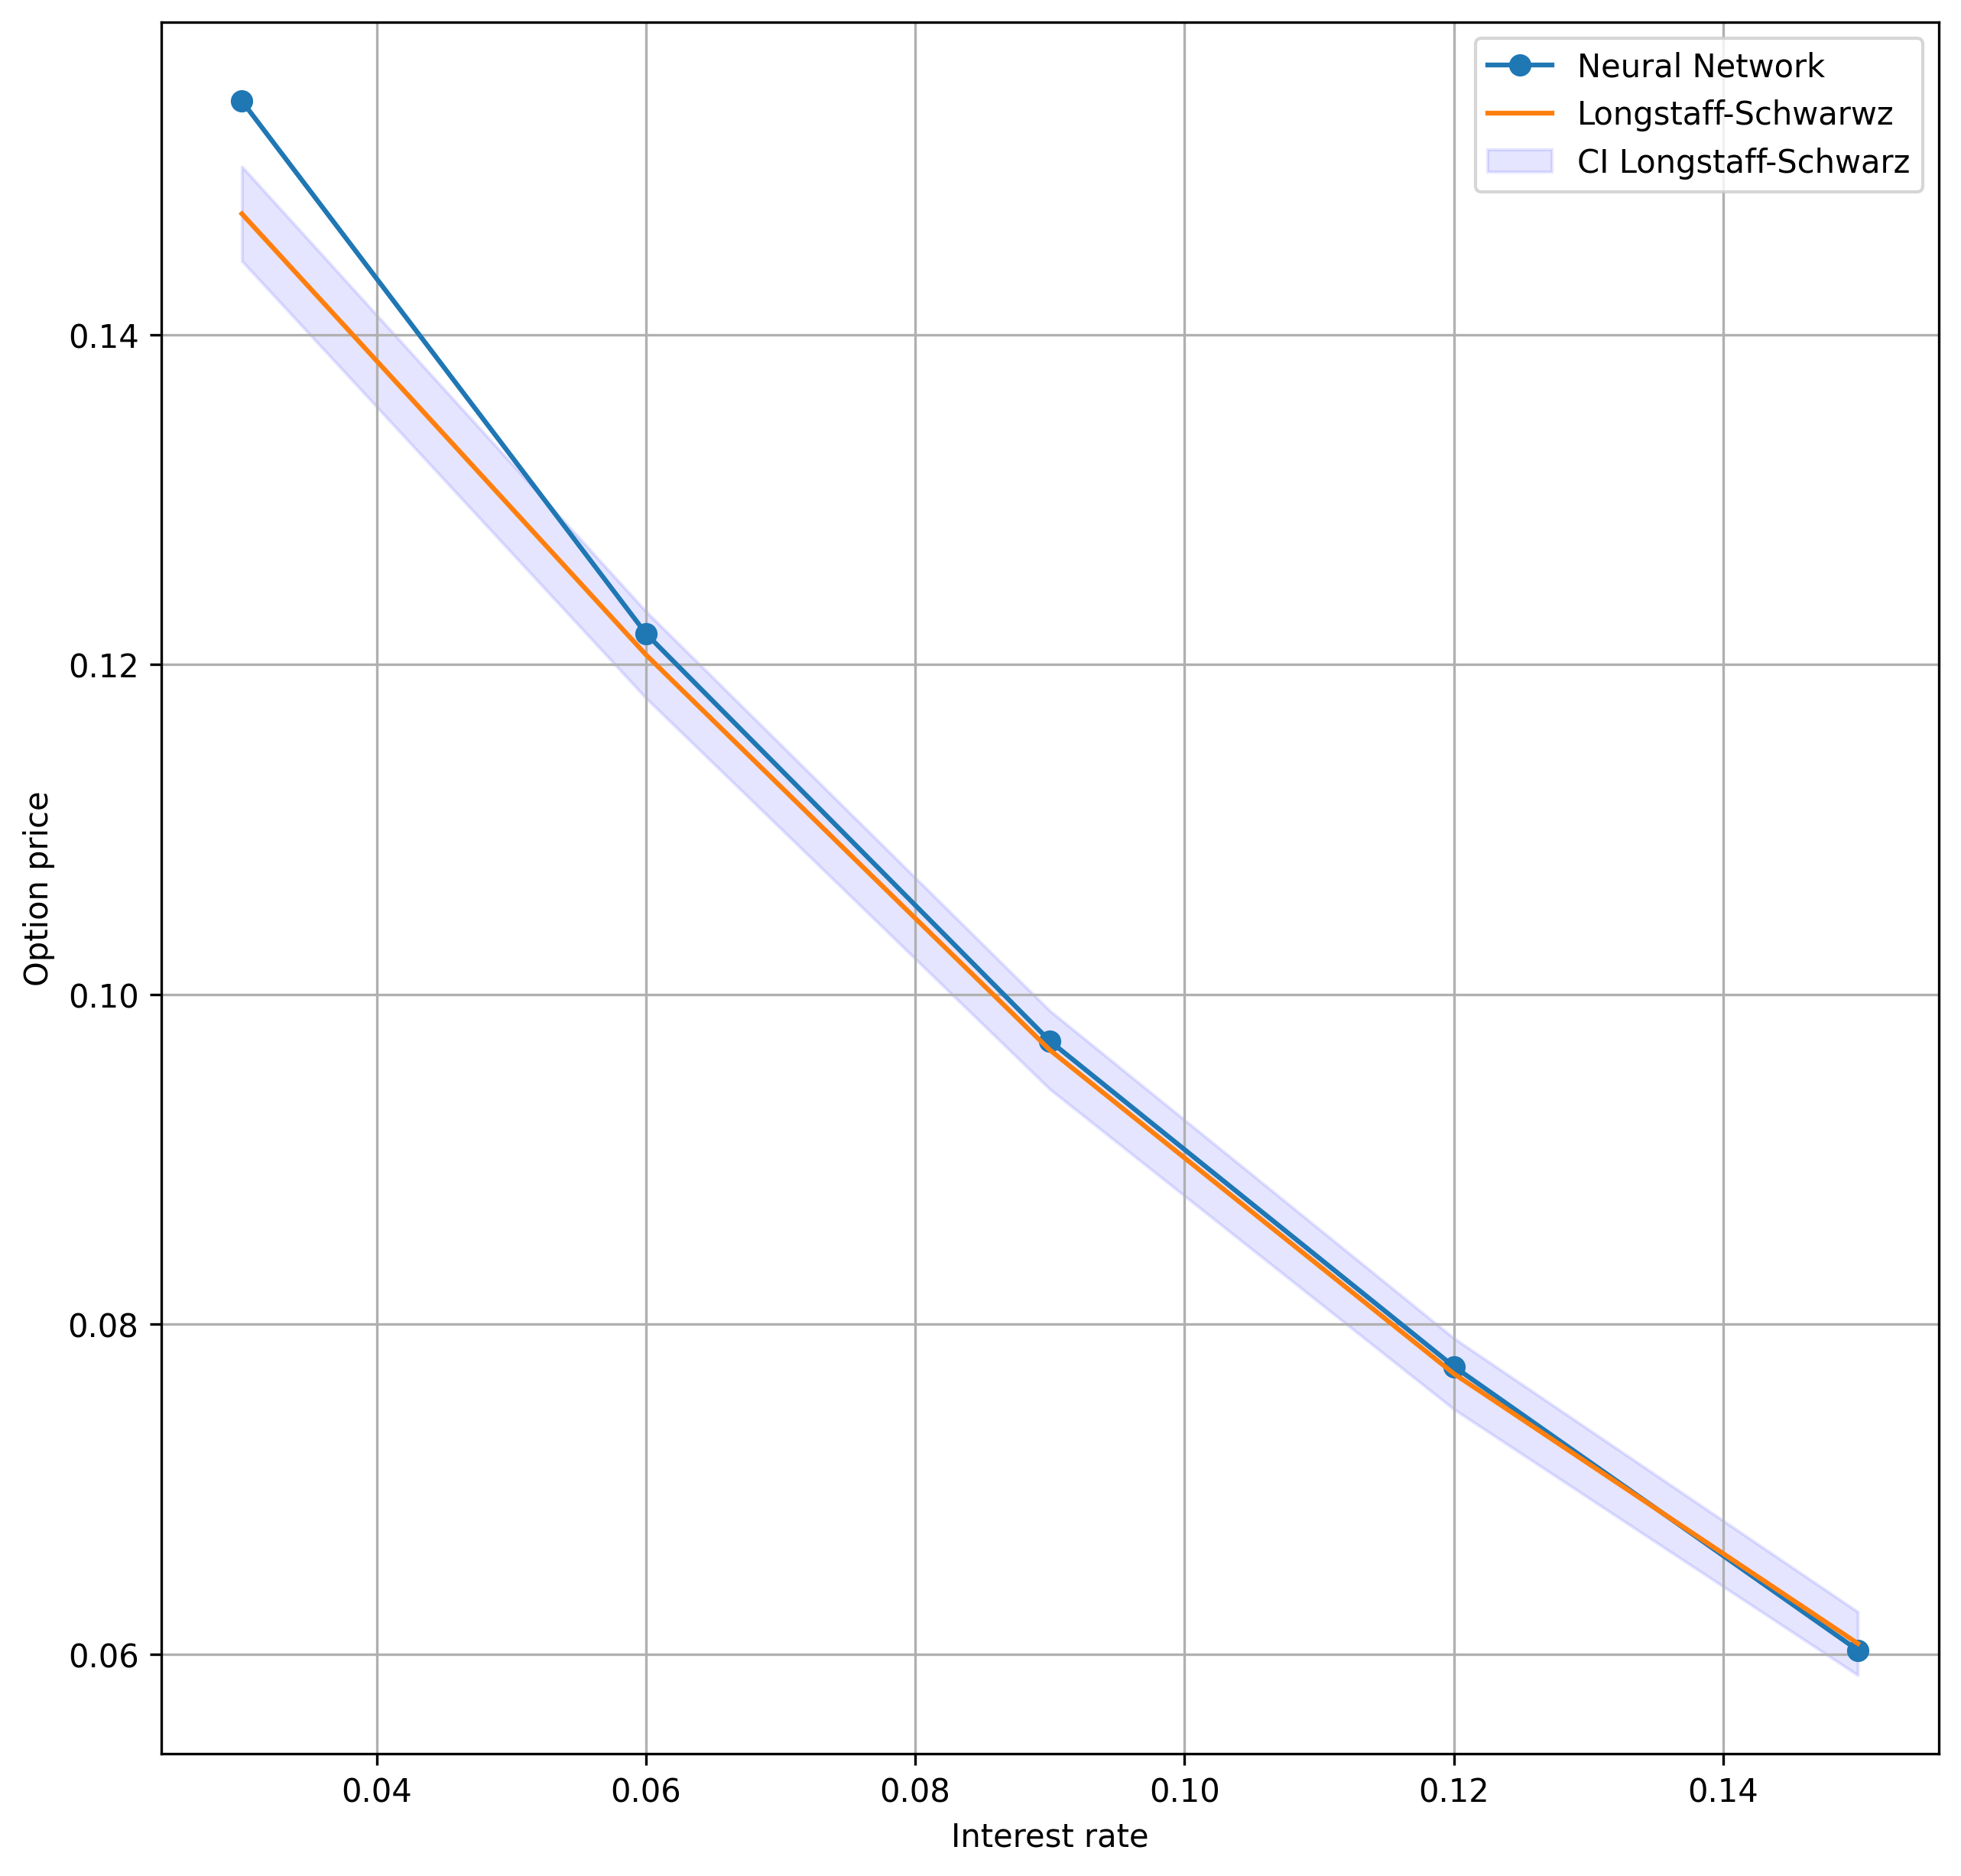

In [20]:
plt.figure(figsize = (10, 10), dpi = 300)
plt.plot(Rs, results_convergence_R, marker = 'o', label = 'Neural Network')
plt.plot(Rs, trial_mean_dict, label = 'Longstaff-Schwarwz')
plt.fill_between(Rs, (trial_mean_dict - trial_se_dict), (trial_mean_dict + trial_se_dict), color = 'b', alpha = .1, label = 'CI Longstaff-Schwarz')

plt.grid()
plt.xlabel('Interest rate')
plt.ylabel('Option price')
plt.legend()
plt.savefig('figures/nn_r.jpeg')
plt.show()

In [21]:
'''Varying Sigma'''

results_convergence_sigmas = []

for ii in tqdm(sigmas):

    s_all = np.array([np.array(GBM_exact(T, S, ii, r, M)) for x in range(realizations)])
    
    # Set up neural network
    nn = Sequential([
            Input(shape=(1)),
            Dense(nodes, activation='relu',trainable=True, kernel_initializer = 'random_uniform'),
            Dense(1,activation='linear',trainable=True, kernel_initializer=keras.initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=None))
            ])
    nn.compile(tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    
    # Train die nn
    Y_train = np.maximum(K - s_all[:,-1], 0)
    X_train = s_all[:,-1]

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
    history = nn.fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=500, verbose=0, callbacks=[callback])
    if history.history['loss'][-1] > 1:
        print("warning. NN didn't converge")

    dates = [3,2,1,0]

    # fit
    nf = neural_bermudan_fitter(r, ii, s_all,  K, dates, epochs = 1000, nodes = nodes)

    # run simulation
    nf.run_pricing_simulation()
    
    # Save price
    results_convergence_sigmas.append(nf.pvt0_nn)
    
'''Longstaff-Schwarz '''

trial_mean_dict = []
trial_se_dict = []

for ii in tqdm(sigmas):
    trial_mean = []
    trial_se = []
    
    for jj in range(30):

        s_all = np.array([np.array(GBM_exact(T, S, ii, r, M)) for x in range(realizations)])
        [option_cash_flow, cash_flows] = value_option_schwarz(T,M,K,s_all, r, realizations, order=2, option="put")

        for time in range(option_cash_flow.shape[1]):
            option_cash_flow[:,time]*=np.exp(-r*(time*dt))

        data = np.zeros(realizations)
        data[0:len(option_cash_flow[option_cash_flow > 0])] = option_cash_flow[option_cash_flow > 0]

        trial_mean.append(np.mean(data))
        trial_se.append(np.std(data)/np.sqrt(realizations))
    
    trial_mean_dict.append(np.mean(trial_mean))
    trial_se_dict.append(np.mean(trial_se))
    
trial_mean_dict = np.array(trial_mean_dict)
trial_se_dict = np.array(trial_se_dict)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\sebas\AppData\Local\Temp/ipykernel_17096/98645413.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))
C:\Users\sebas\AppData\Local\Temp/ipykernel_17096/98645413.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.04s/it]


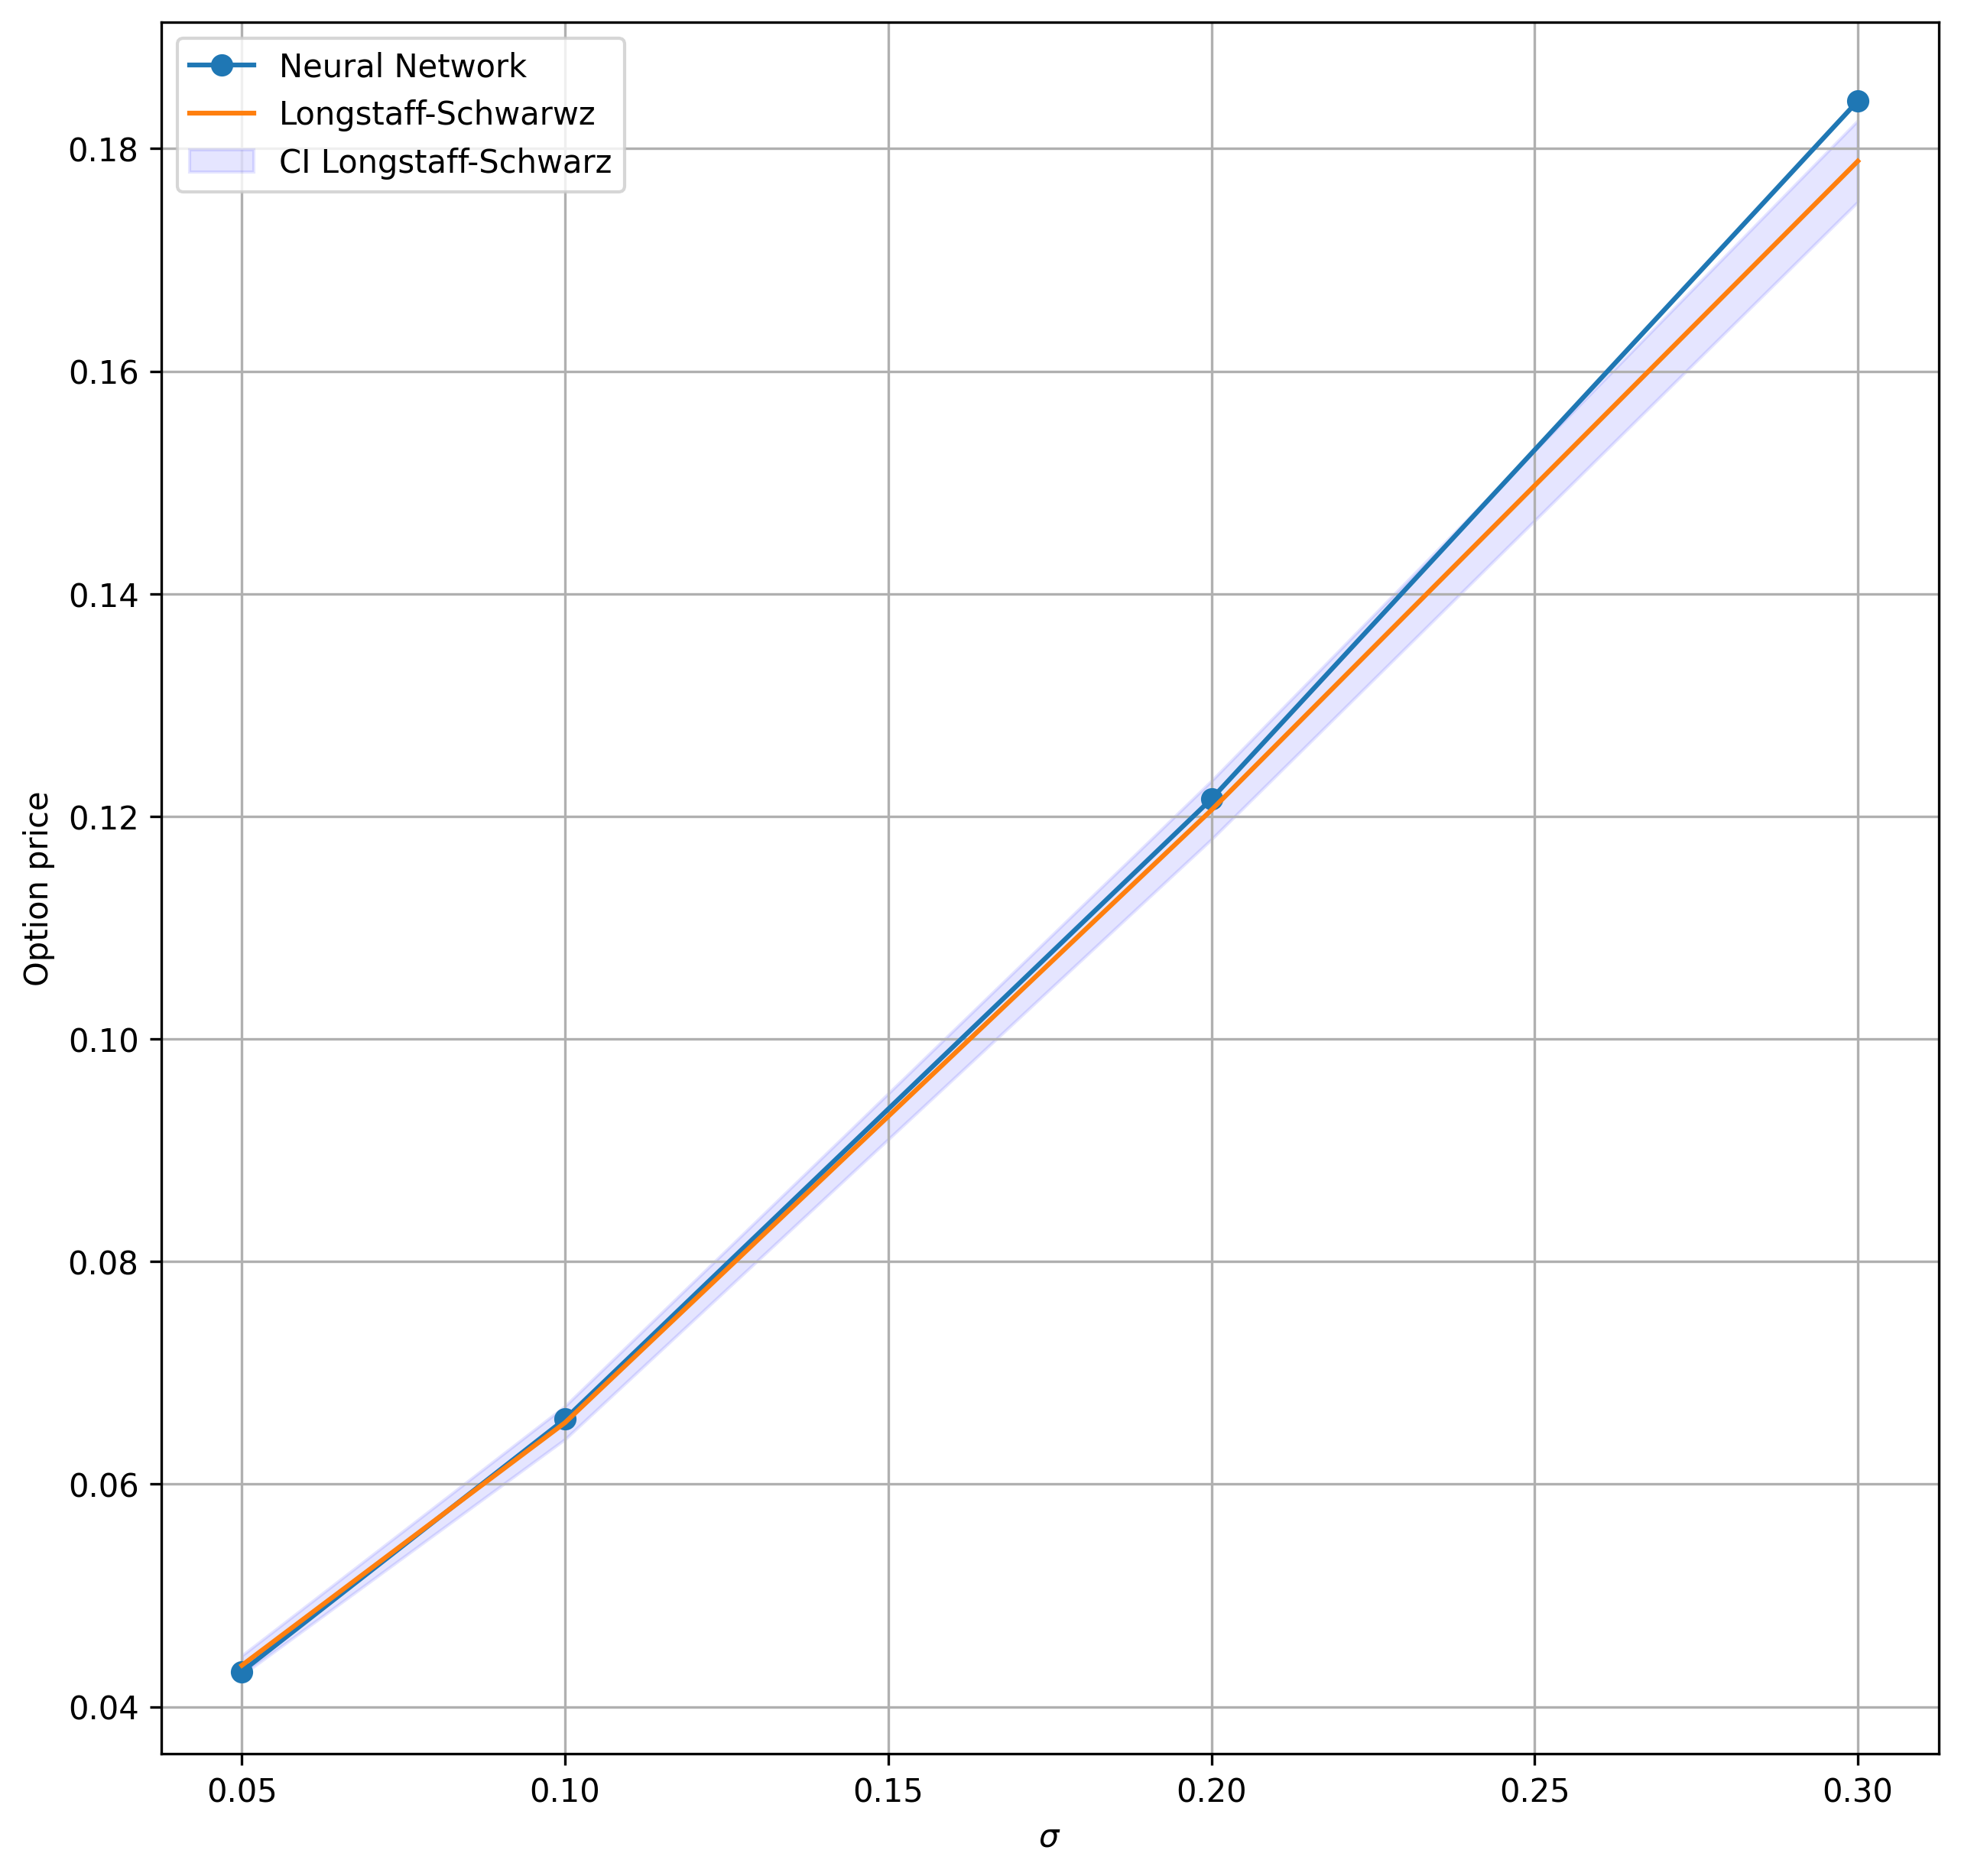

In [22]:
plt.figure(figsize = (10, 10), dpi = 300)
plt.plot(sigmas, results_convergence_sigmas, marker = 'o', label = 'Neural Network')
plt.plot(sigmas, trial_mean_dict, label = 'Longstaff-Schwarwz')
plt.fill_between(sigmas, (trial_mean_dict - trial_se_dict), (trial_mean_dict + trial_se_dict), color = 'b', alpha = .1, label = 'CI Longstaff-Schwarz')

plt.grid()
plt.xlabel('$\sigma$')
plt.ylabel('Option price')
plt.legend()
plt.savefig('figures/nn_sigma.jpeg')
plt.show()

### Varying strike prices

In [23]:
'''Varying K'''

results_convergence_K = []

for ii in tqdm(Ks):

    s_all = np.array([np.array(GBM_exact(T, S, sigma, r, M)) for x in range(realizations)])
    
    # Set up neural network
    nn = Sequential([
            Input(shape=(1)),
            Dense(nodes, activation='relu',trainable=True, kernel_initializer = 'random_uniform'),
            Dense(1,activation='linear',trainable=True, kernel_initializer=keras.initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=None))
            ])
    nn.compile(tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    
    # Train die nn
    Y_train = np.maximum(ii - s_all[:,-1], 0)
    X_train = s_all[:,-1]

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
    history = nn.fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=500, verbose=0, callbacks=[callback])
    if history.history['loss'][-1] > 1:
        print("warning. NN didn't converge")

    dates = [3,2,1,0]

    # fit
    nf = neural_bermudan_fitter(r, sigma, s_all,  ii, dates, epochs = 1000, nodes = nodes)

    # run simulation
    nf.run_pricing_simulation()
    
    # Save price
    results_convergence_K.append(nf.pvt0_nn)
    
'''Longstaff-Schwarz '''

trial_mean_dict = []
trial_se_dict = []

for ii in tqdm(Ks):
    trial_mean = []
    trial_se = []
    
    for jj in range(30):

        s_all = np.array([np.array(GBM_exact(T, S, sigma, r, M)) for x in range(realizations)])
        [option_cash_flow, cash_flows] = value_option_schwarz(T,M,ii, s_all, r, realizations, order=2, option="put")

        for time in range(option_cash_flow.shape[1]):
            option_cash_flow[:,time]*=np.exp(-r*(time*dt))

        data = np.zeros(realizations)
        data[0:len(option_cash_flow[option_cash_flow > 0])] = option_cash_flow[option_cash_flow > 0]

        trial_mean.append(np.mean(data))
        trial_se.append(np.std(data)/np.sqrt(realizations))
    
    trial_mean_dict.append(np.mean(trial_mean))
    trial_se_dict.append(np.mean(trial_se))
    
trial_mean_dict = np.array(trial_mean_dict)
trial_se_dict = np.array(trial_se_dict)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\sebas\AppData\Local\Temp/ipykernel_17096/98645413.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))
C:\Users\sebas\AppData\Local\Temp/ipykernel_17096/98645413.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


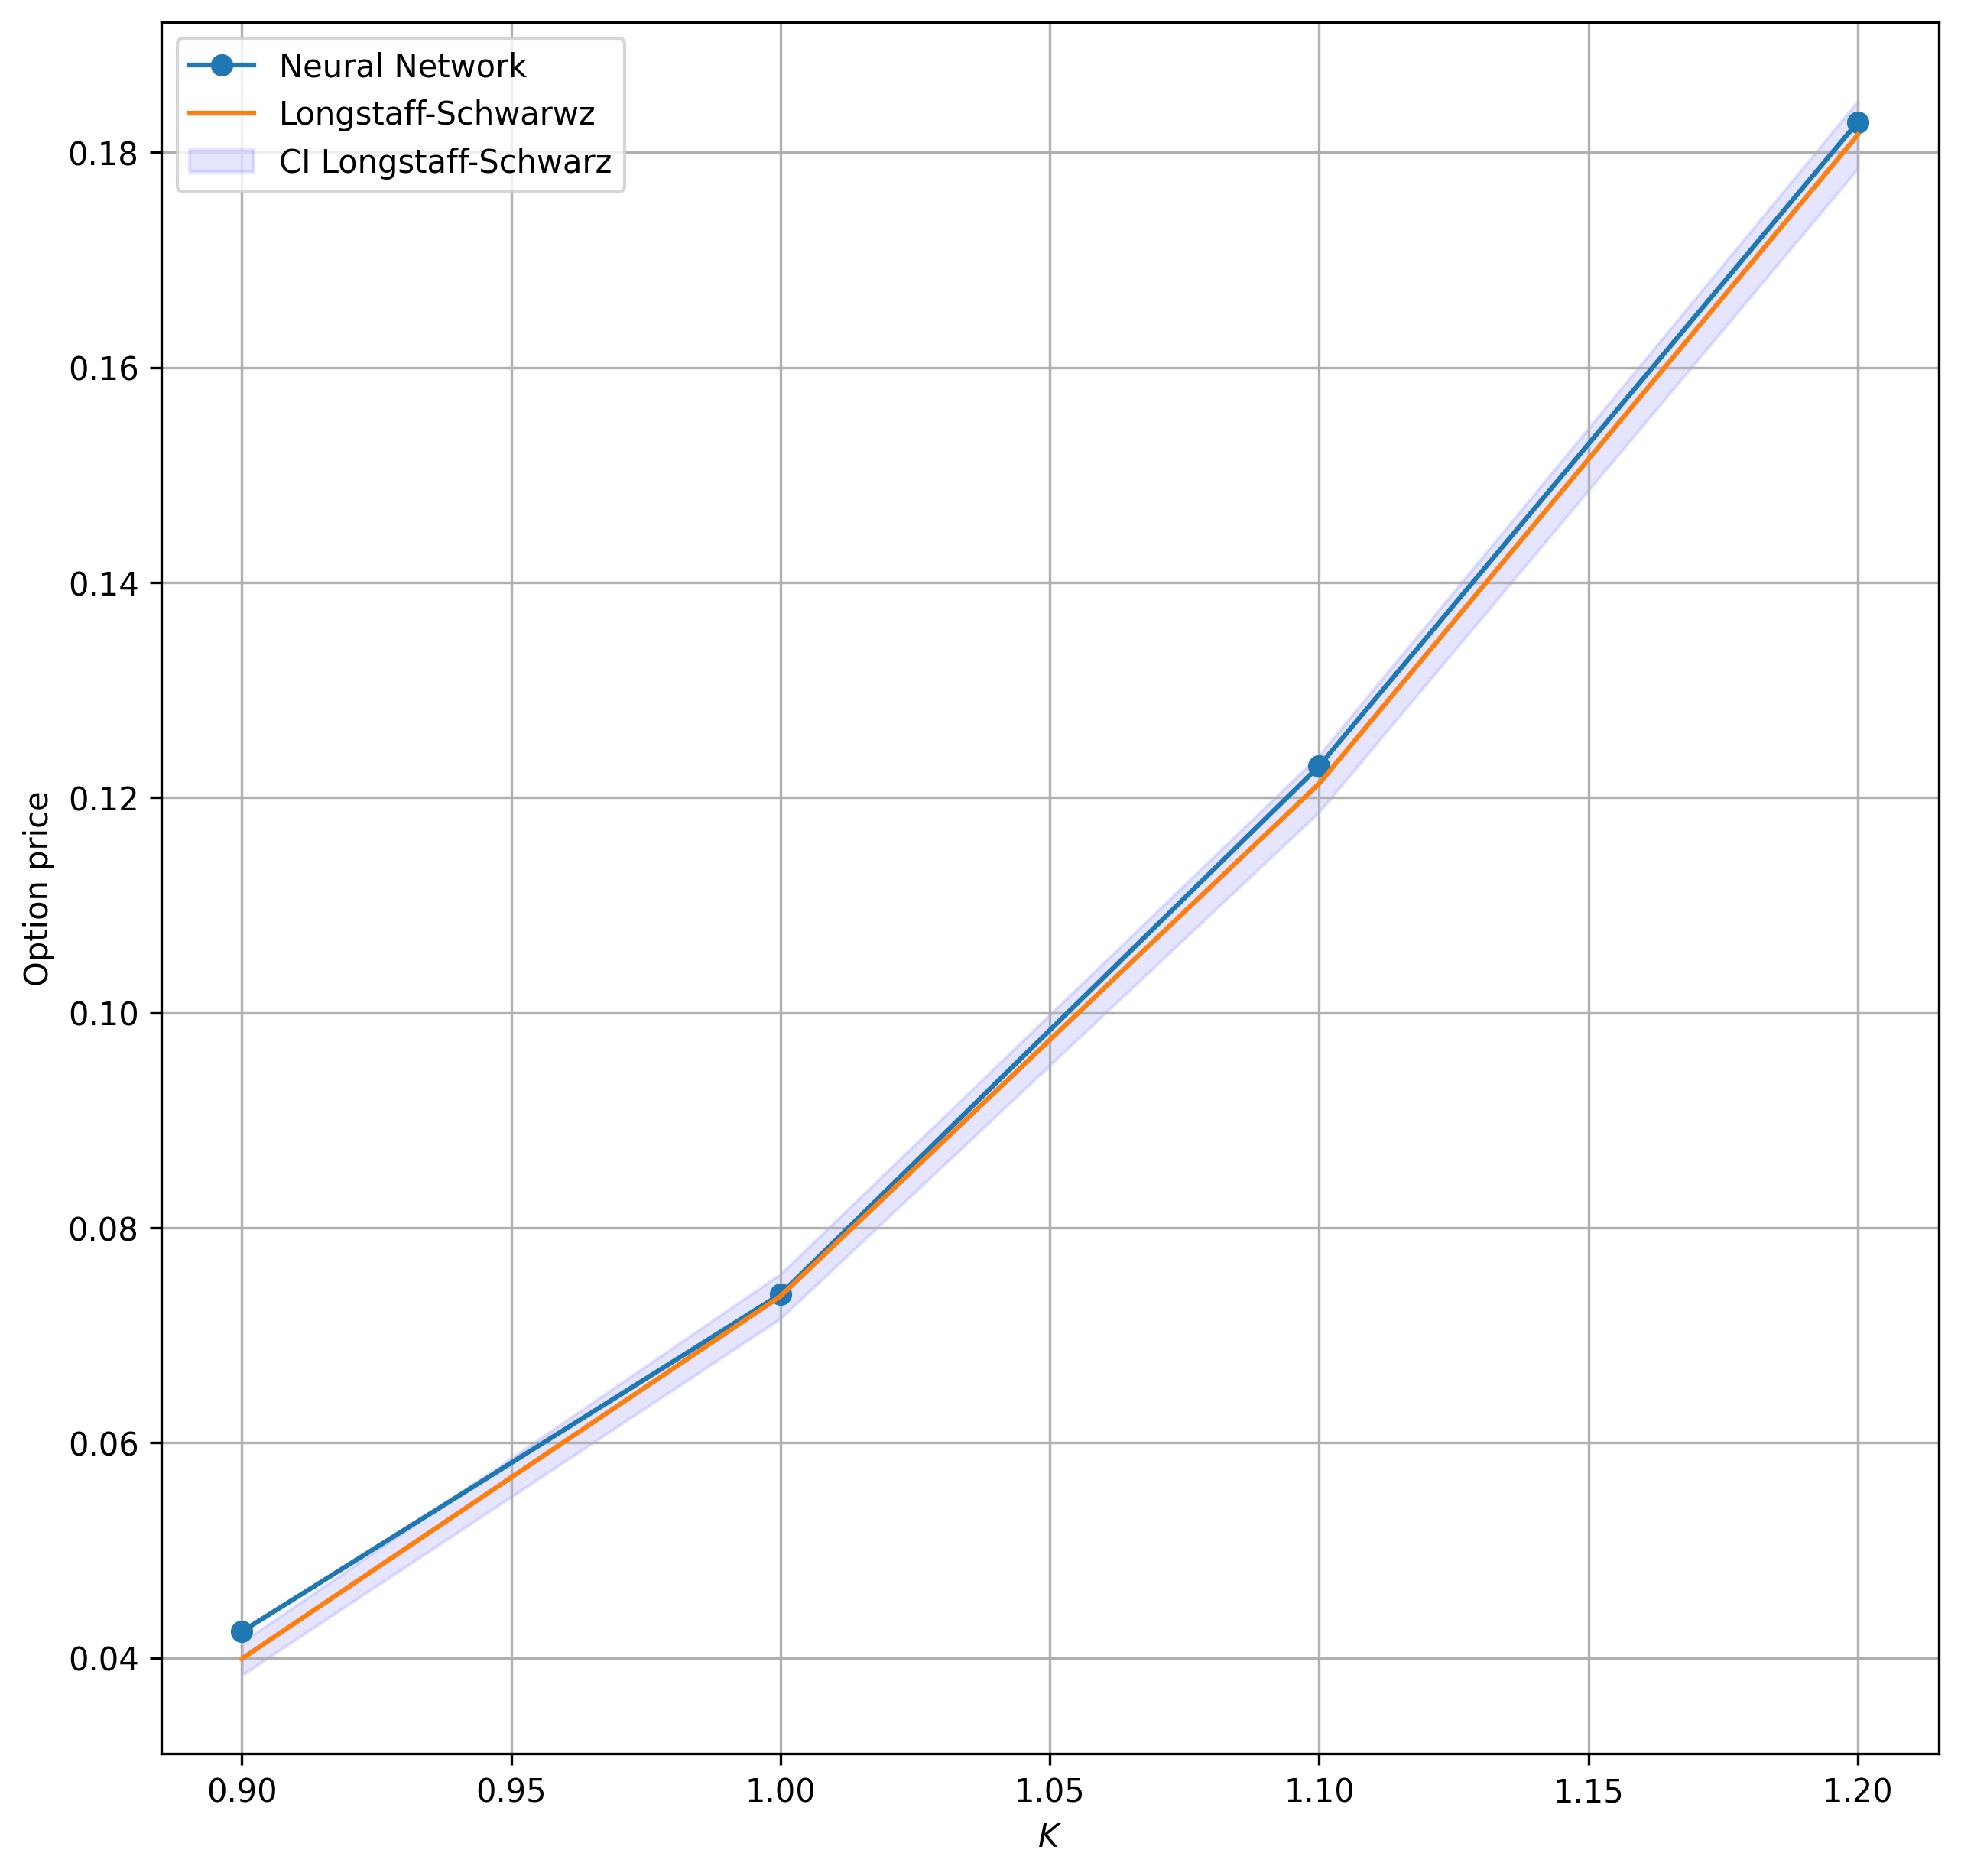

In [24]:
plt.figure(figsize = (10, 10), dpi = 300)
plt.plot(Ks, results_convergence_K, marker = 'o', label = 'Neural Network')
plt.plot(Ks, trial_mean_dict, label = 'Longstaff-Schwarwz')
plt.fill_between(Ks, (trial_mean_dict - trial_se_dict), (trial_mean_dict + trial_se_dict), color = 'b', alpha = .1, label = 'CI Longstaff-Schwarz')

plt.grid()
plt.xlabel('$K$')
plt.ylabel('Option price')
plt.legend()
plt.savefig('figures/nn_k.jpeg')
plt.show()

## New

In [101]:
nf = neural_bermudan_fitter(r, sigma, s_all,  K, dates, epochs = 1000, nodes= 10)

# run simulation
nf.run_pricing_simulation()

C:\Users\sebas\AppData\Local\Temp/ipykernel_16232/3018685175.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))
C:\Users\sebas\AppData\Local\Temp/ipykernel_16232/3018685175.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))


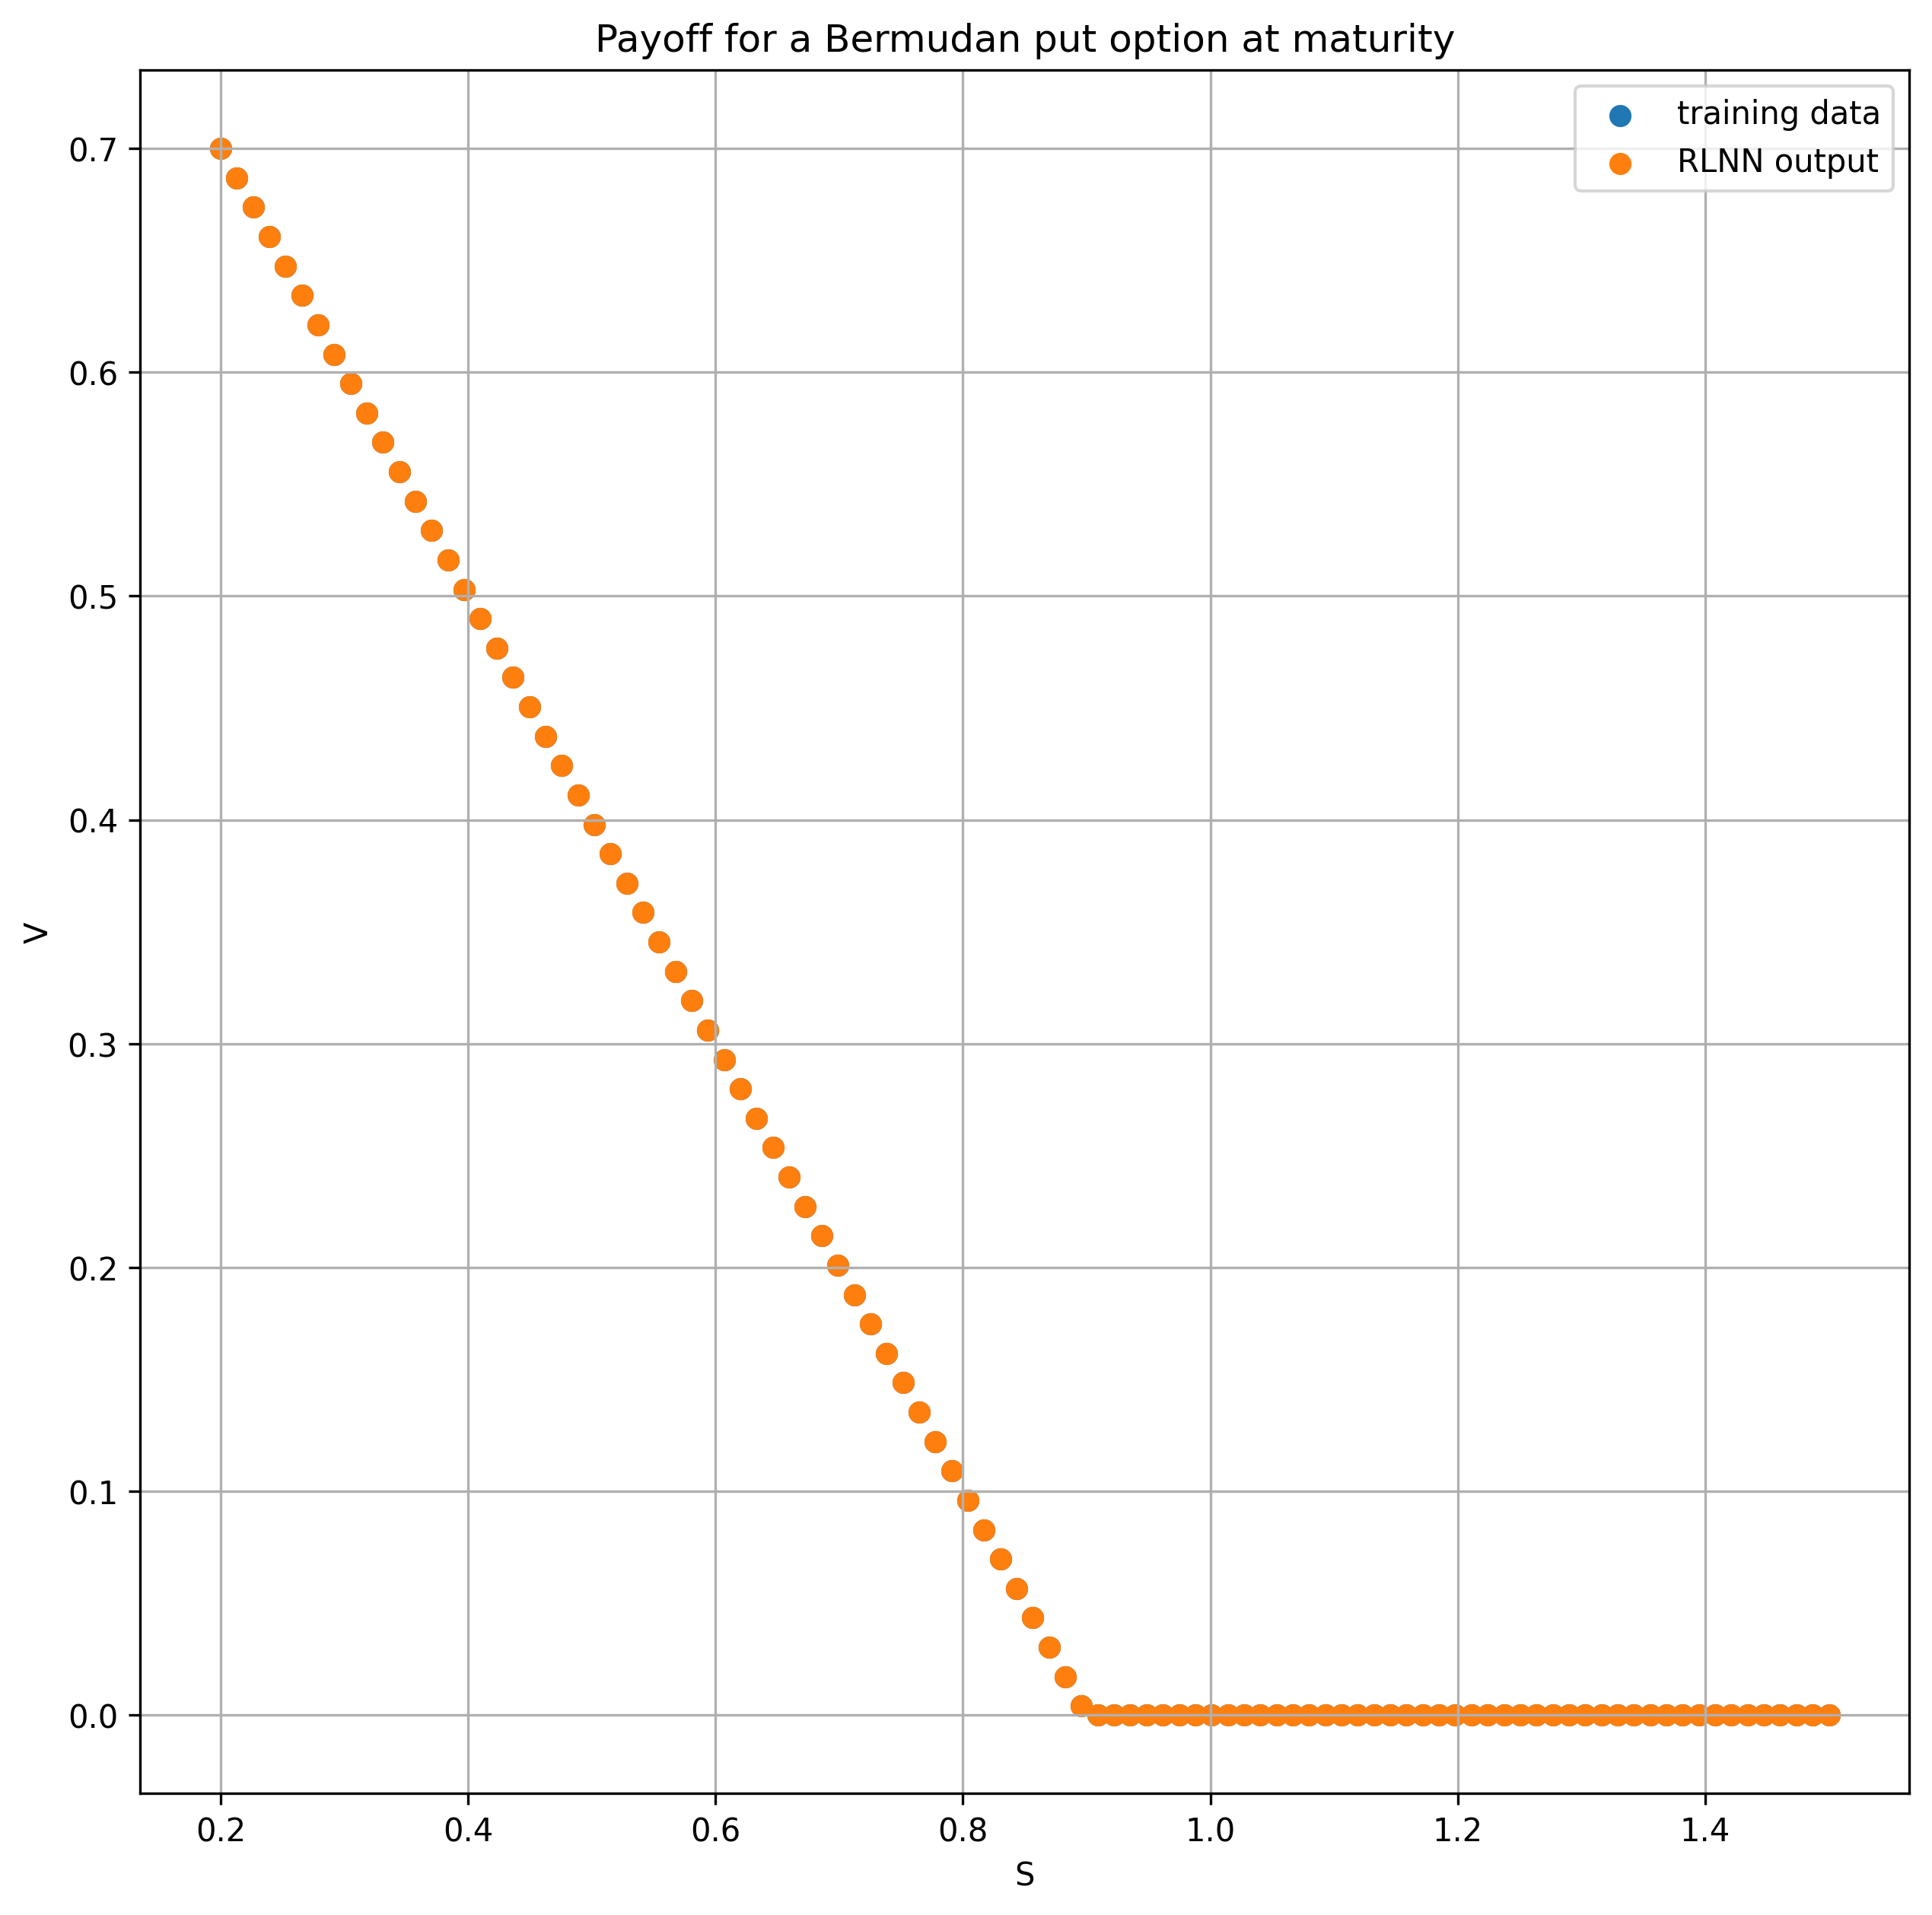

In [113]:
m=0

X = np.linspace(.2,1.5,100)
plt.figure(figsize=(10,10), dpi = 300)
plt.title("Payoff for a Bermudan put option at maturity")
plt.scatter(X, np.maximum(K - X, 0), label="training data")
plt.scatter(X, nf.nnets[m].predict(X.reshape(-1,1)), label="RLNN output")
plt.legend()
plt.xlabel("S")
plt.ylabel("V")
plt.grid()
plt.savefig('figures/improvement1.jpeg')

plt.show()

In [103]:
m=0

train_Y = np.maximum(nf.Q_hats[m], np.maximum(K - s_all[:,dates[m+1]], 0))

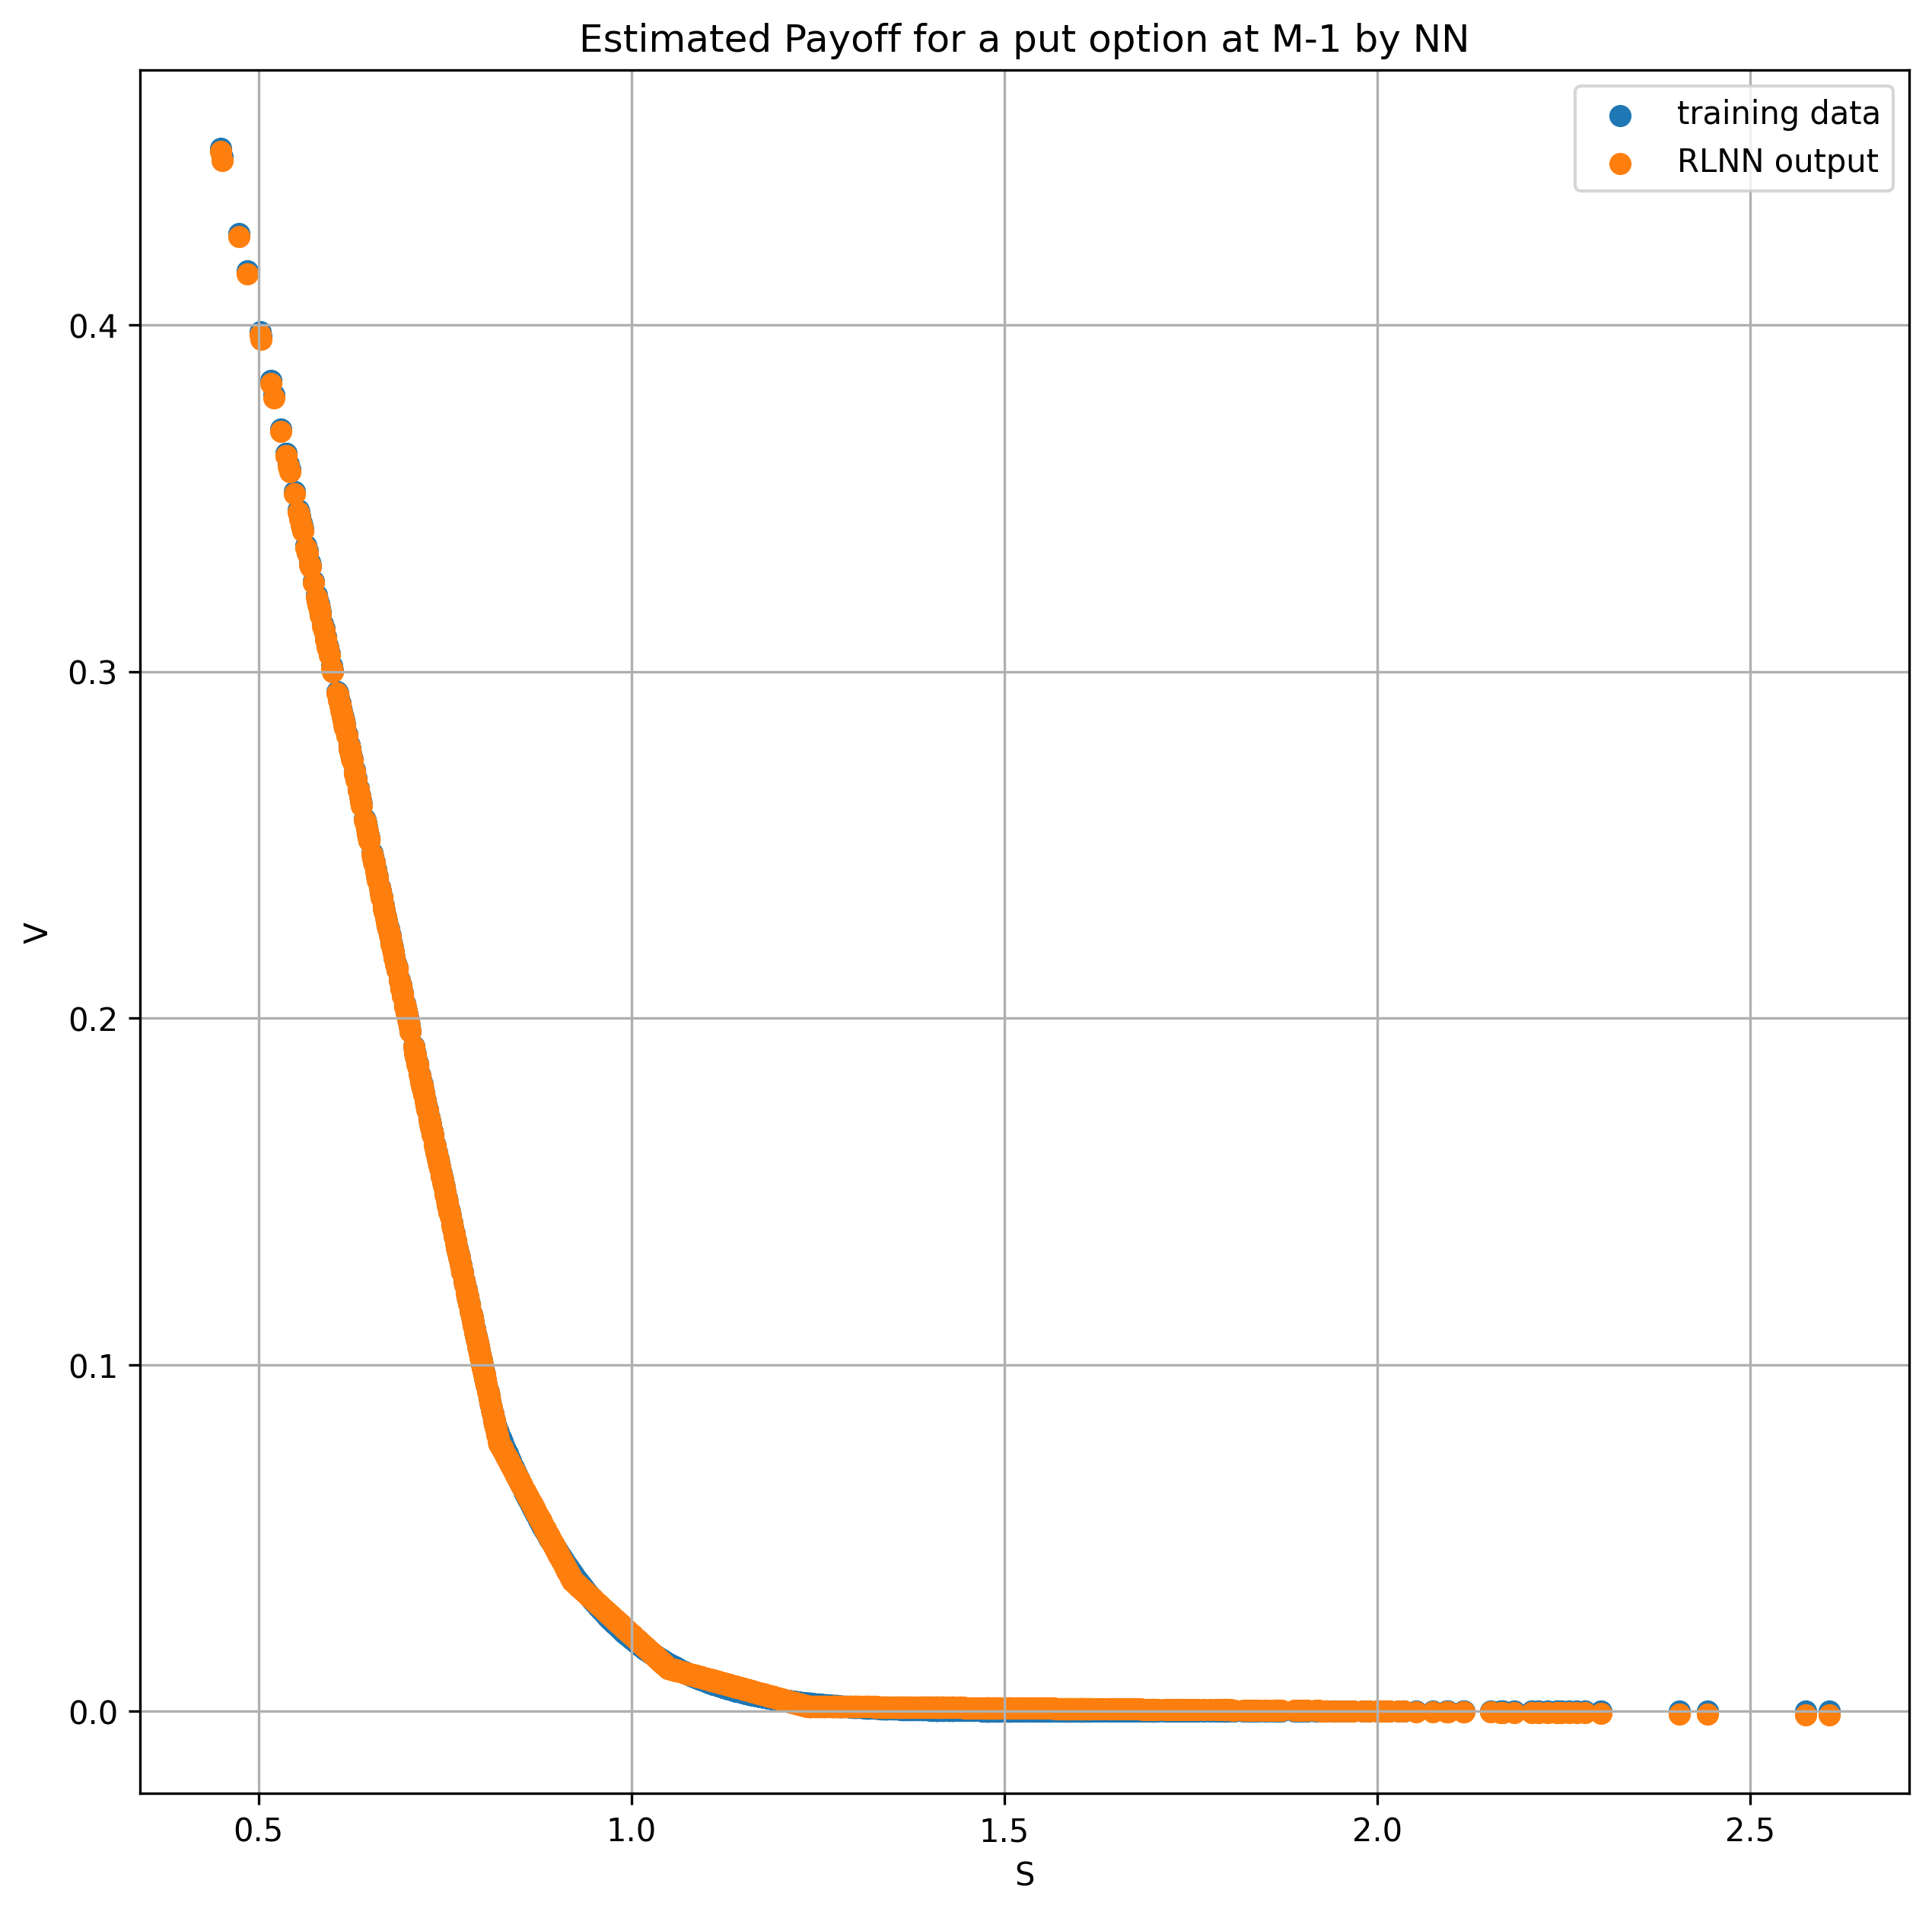

In [116]:
plt.figure(figsize=(10,10), dpi = 300)
plt.title(f"Estimated Payoff for a put option at M-{1} by NN")
plt.scatter(s_all[:,dates[m+1]], train_Y, label="training data")
plt.scatter(s_all[:,dates[m+1]], nf.nnets[m+1].predict(s_all[:,dates[m+1]]), label="RLNN output")
plt.xlabel("S")
plt.ylabel("V")
plt.legend()
plt.grid()
plt.savefig('figures/improvement2.jpeg')


## Hedging

In [169]:
# Variables used
T = M = N = 4
K = 1.1
S = 1
sigma = 0.2
r = 0.06
realizations = 1000
delta = 0
t = 1
dt = T/M

In [154]:
s_all = np.array([np.array(GBM_exact(T, S, sigma, r, M)) for x in range(realizations)])
    
# Set up neural network
nn = Sequential([
        Input(shape=(1)),
        Dense(10,activation='relu',trainable=True, kernel_initializer = 'random_uniform'),
        Dense(1,activation='linear',trainable=True, kernel_initializer=keras.initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=None))
        ])
nn.compile(tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Train die nn
Y_train = np.maximum(K - s_all[:,-1], 0)
X_train = s_all[:,-1]

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
history = nn.fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=500, verbose=0, callbacks=[callback])
if history.history['loss'][-1] > 1:
    print("warning. NN didn't converge")

dates = [3,2,1,0]

# fit
nf = neural_bermudan_fitter(r, sigma, s_all,  K, dates, epochs = 1000, nodes= 10)

# run simulation
nf.run_pricing_simulation()

C:\Users\sebas\AppData\Local\Temp/ipykernel_7372/2883660184.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))
C:\Users\sebas\AppData\Local\Temp/ipykernel_7372/2883660184.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))


In [ ]:
#params = [strike_array.reshape(self.nodes,1), deposit_list.reshape(self.nodes,1), pfl_wts.reshape(self.nodes,1)]

In [177]:
final_postions = []
stock_tracker = []
for kech in tqdm(range(5)):

    
    s_all = np.array([np.array(GBM_exact(T, S, sigma, r, M)) for x in range(realizations)])
    
    # Set up neural network
    nn = Sequential([
            Input(shape=(1)),
            Dense(10,activation='relu',trainable=True, kernel_initializer = 'random_uniform'),
            Dense(1,activation='linear',trainable=True, kernel_initializer=keras.initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=None))
            ])
    nn.compile(tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train die nn
    Y_train = np.maximum(K - s_all[:,-1], 0)
    X_train = s_all[:,-1]

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
    history = nn.fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=500, verbose=0, callbacks=[callback])
    if history.history['loss'][-1] > 1:
        print("warning. NN didn't converge")

    dates = [3,2,1,0]

    # fit
    nf = neural_bermudan_fitter(r, sigma, s_all,  K, dates, epochs = 1000, nodes= 10)

    # run simulation
    nf.run_pricing_simulation()
    
    # Find the positions
    positions = []

    for stock in s_all[:,1]:
        value = 0

        for jj in range(len(nf.positions[-1])):
            if nf.positions[-1][jj] == 'C':
                value += np.maximum(stock - nf.hedge[-1][0][jj], 0) * nf.hedge[-1][2][jj]
            elif nf.positions[-1][jj] == 'P':
                value += np.maximum(nf.hedge[-1][0][jj] - stock, 0 ) * nf.hedge[-1][2][jj]

        positions.append(value)
    positions = np.array(positions)
    bermudan_t1 = np.maximum(K - s_all[:, 1], 0).reshape(-1,1)
    hedge_error = abs(bermudan_t1 - positions)
    
    final_postions.append(hedge_error)
    stock_tracker.append(s_all)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\sebas\AppData\Local\Temp/ipykernel_7372/2883660184.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))
C:\Users\sebas\AppData\Local\Temp/ipykernel_7372/2883660184.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:51<00:00, 22.33s/it]


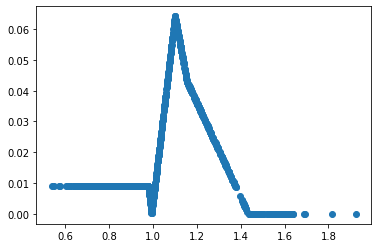

In [186]:
plt.scatter(stock_tracker[0][:,1], final_postions[0])

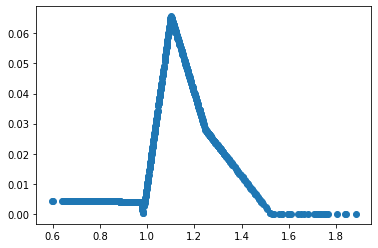

In [187]:
plt.scatter(stock_tracker[1][:,1], final_postions[1])

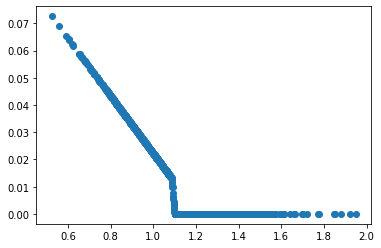

In [188]:
plt.scatter(stock_tracker[2][:,1], final_postions[2])

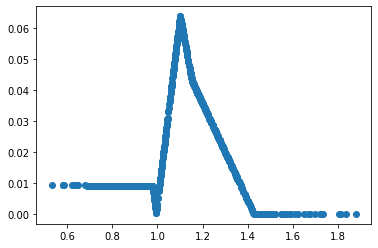

In [189]:
plt.scatter(stock_tracker[3][:,1], final_postions[3])

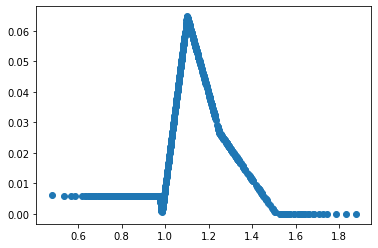

In [190]:
plt.scatter(stock_tracker[4][:,1], final_postions[4])

## Hedge simulation fixed


In [103]:
# Variables used
T = 10
M = 4
K = 1.1
S = 1
sigma = 0.2
r = 0.06
realizations = 1000
delta = 0
dt = T/M

# Define one simulation
trial_mean = []
trial_se = []


s_all = np.array(GBM_online(S, r, sigma, T, dt, realizations))
[option_cash_flow, cash_flows] = value_option_schwarz(T, M,K,s_all, r, realizations, order=2, option="put")

for time in range(option_cash_flow.shape[1]):
    option_cash_flow[:,time]*=np.exp(-r*(time*dt))

data = np.zeros(realizations)
data[0:len(option_cash_flow[option_cash_flow > 0])] = option_cash_flow[option_cash_flow > 0]

In [104]:
stopping_rule = np.where(option_cash_flow > 0, 1,0)

In [106]:
neural_hedge = np.zeros([realizations, M+1])

In [107]:
nf = neural_bermudan_fitter(r, sigma, M, S, K, dates, learning_rate= 0.001, T=T, epochs = 1000, nodes = 12)
# run simulation
nf.run_pricing_simulation()

C:\Users\JWant\AppData\Local\Temp\ipykernel_3044\3506770935.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))
C:\Users\JWant\AppData\Local\Temp\ipykernel_3044\3506770935.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))


In [108]:
# Find the positions
#positions = []

for t in range(0, M):
    print(t)
    positions = []
    
    for stock in s_all[:,t+1]:
        value = 0

        for jj in range(len(nf.positions[-1])):
            if nf.positions[-1][jj] == 'C':
                value += np.maximum(stock - nf.hedge[M-t-2][0][jj], 0) * nf.hedge[M-t-2][2][jj]
            elif nf.positions[-1][jj] == 'P':
                value += np.maximum(nf.hedge[M-t-2][0][jj] - stock, 0 ) * nf.hedge[M-t-2][2][jj]

        positions.append(np.exp((t+1)*dt *-r) * value)
    neural_hedge[:, t+1] = positions
    #positions = np.array(positions)


0
1
2
3


C:\Users\JWant\AppData\Local\Temp\ipykernel_3044\165169619.py:18: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  neural_hedge[:, t+1] = positions


In [109]:
neural_hedge_stopping = neural_hedge * stopping_rule

In [110]:
diff = option_cash_flow - neural_hedge_stopping
stock_stopping = s_all * stopping_rule

In [111]:
data = np.zeros(realizations)
data[0:len(option_cash_flow[option_cash_flow > 0])] = option_cash_flow[option_cash_flow > 0]
data = data[data!=0]

In [112]:
data_diff = np.zeros(realizations)
data_diff[0:len(diff[diff != 0])] = diff[diff != 0]
data_diff = data_diff[data_diff != 0]

In [113]:
data_stock = np.zeros(realizations)
data_stock[0:len(stock_stopping[stock_stopping != 0])] = stock_stopping[stock_stopping != 0]
data_stock = data_stock[data_stock!=0]

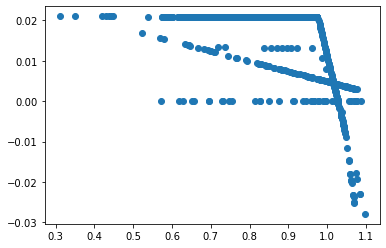

In [114]:
plt.scatter(data_stock, (data_diff))

In [115]:
'''
Error op verschil tijden
'''

neural_hedge_stopping = neural_hedge * stopping_rule
diff = (option_cash_flow - neural_hedge_stopping)
#diff = abs((option_cash_flow - neural_hedge_stopping) / neural_hedge_stopping)
stock_stopping = s_all * stopping_rule

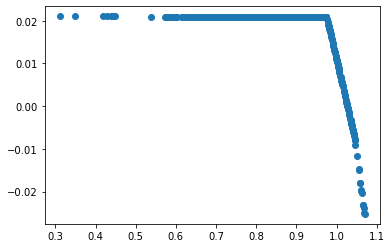

In [116]:
x1 = stock_stopping[:,1][stock_stopping[:,1] != 0 ]
y1 = (diff[:,1][diff[:,1]!=0] )
plt.scatter(x1,y1)

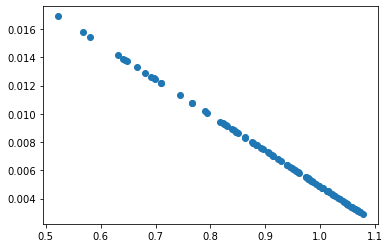

In [117]:
x2 = stock_stopping[:,2][stock_stopping[:,2] != 0 ]
y2 = diff[:,2][diff[:,2]!=0]
plt.scatter(x2,y2)

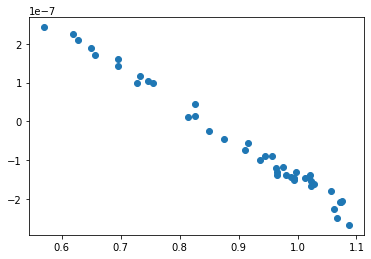

In [118]:
x3 = stock_stopping[:,3][stock_stopping[:,3] != 0 ]
y3 =diff[:,3][diff[:,3]!=0]
plt.scatter(x3,y3)

In [119]:
print(np.mean(y1))
print(np.mean(y2))
print(np.mean(y3))

0.01645701298365569
0.007061774520649466
-5.406555379896254e-08


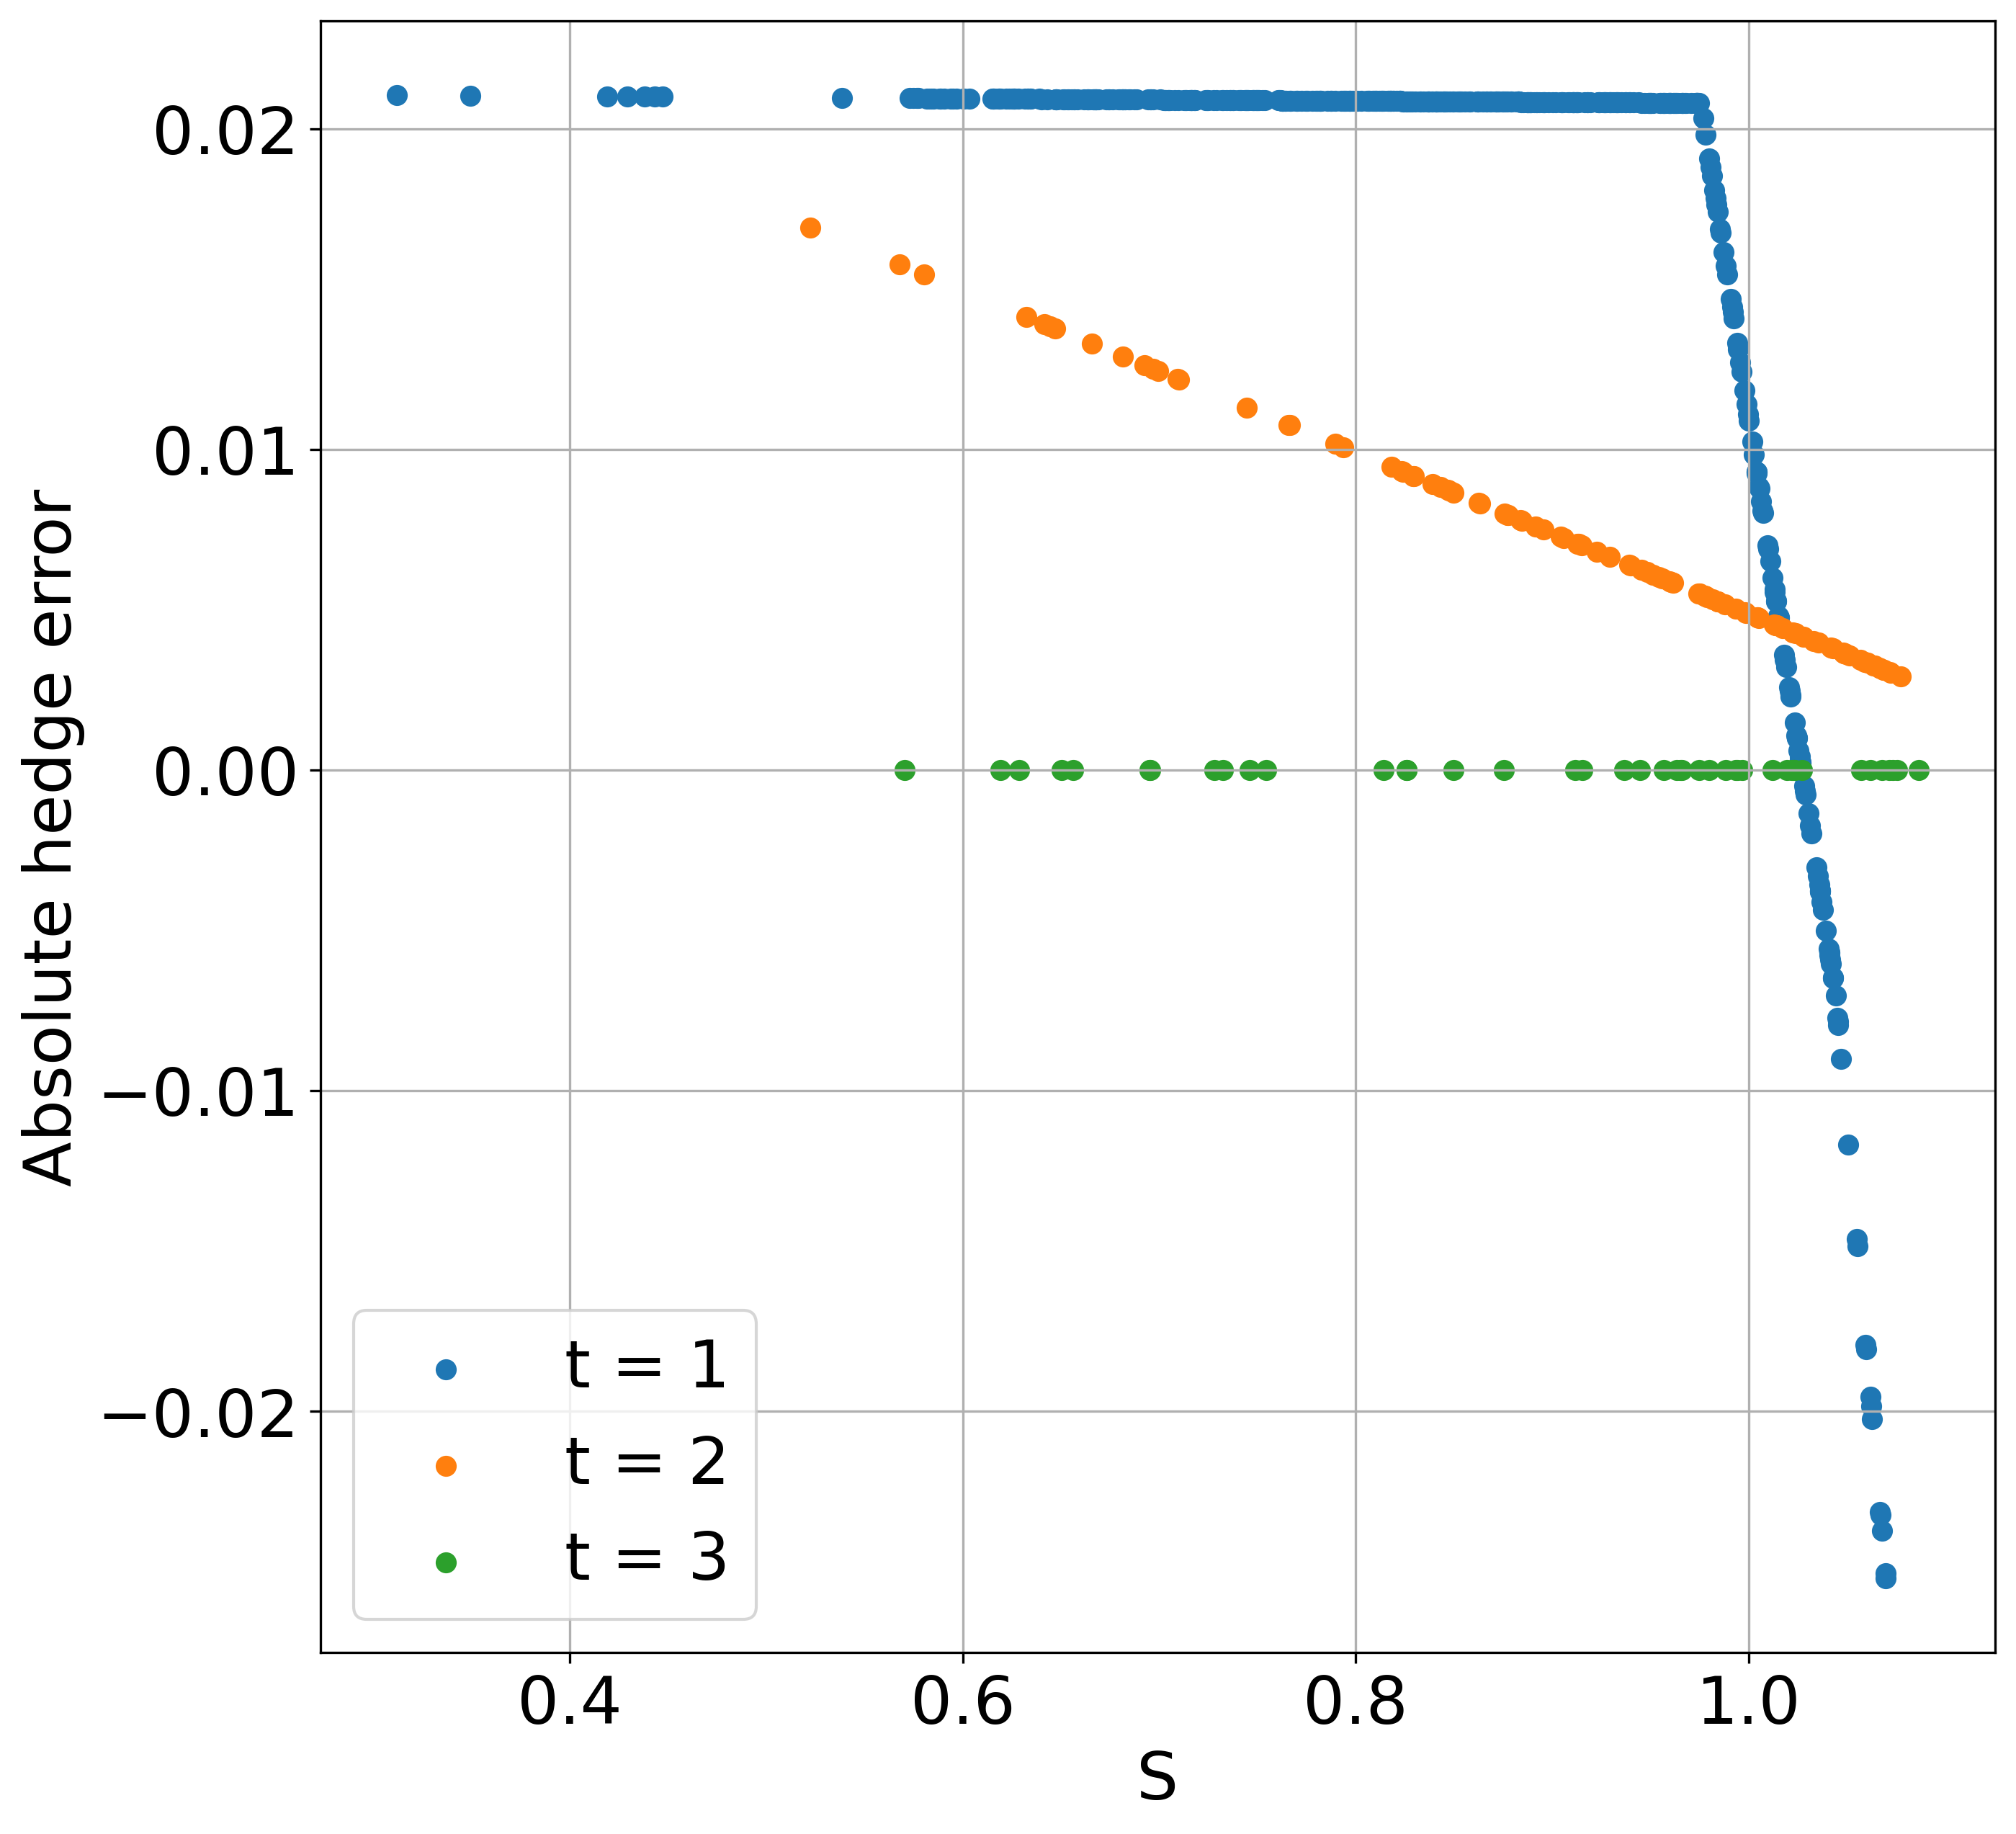

In [120]:
plt.figure(figsize = (10,10), dpi = 300)
plt.rcParams.update({'font.size': 22})
plt.scatter(x1,y1, label = 't = 1')
plt.scatter(x2,y2, label = 't = 2')
plt.scatter(x3,y3, label = 't = 3')
plt.grid()
plt.legend()
plt.xlabel('S')
plt.ylabel('Absolute hedge error')
plt.savefig('figures/hedgeerror.jpeg')
plt.show()

## Extracting Delta

In [311]:
nf = neural_bermudan_fitter(r, sigma, M, S, K, dates, learning_rate= 0.001, T=T, epochs = 1000, nodes = 12)
# run simulation
nf.run_pricing_simulation()

C:\Users\JWant\AppData\Local\Temp\ipykernel_3044\2013498954.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))
C:\Users\JWant\AppData\Local\Temp\ipykernel_3044\2013498954.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))


In [312]:
realizations=10

In [324]:
delta = np.zeros([realizations, M])
vega = np.zeros([realizations, M])
neural_hedge = np.zeros([realizations, M])
d1_stocks = np.linspace(0.5,1.5,realizations)

for t in range(0, M):
    positions = []
    delta_t = []
    
    g=0
    for stock in d1_stocks:
        value = 0

        
        for jj in range(len(nf.positions[-1])):
            if nf.positions[M-t-1][jj] == 'C':
                delta[g,t] += norm.cdf(d1(stock, r, 0, 0, dt, nf.hedge[M-t-1][0][jj], sigma)) * nf.hedge[M-t-2][2][jj]
                vega[g,t] += norm.pdf(d1(stock, r, 0, 0, dt, nf.hedge[M-t-1][0][jj], sigma)) * nf.hedge[M-t-2][2][jj]
                
            elif nf.positions[M-t-2][jj] == 'P':
                delta[g,t] += -norm.cdf(d1(stock, r, 0, 0, dt, nf.hedge[M-t-1][0][jj], sigma)) * nf.hedge[M-t-2][2][jj]
                vega[g,t] += norm.pdf(d1(stock, r, 0, 0, dt, nf.hedge[M-t-1][0][jj], sigma)) * nf.hedge[M-t-2][2][jj]
        g+=1

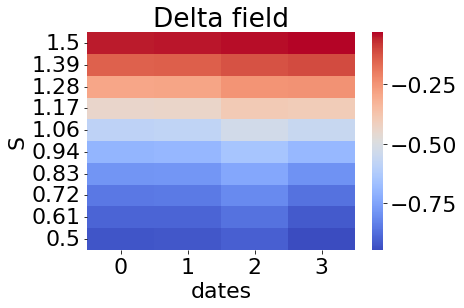

In [325]:
ax=plt.axes()
sns.heatmap(delta,cmap="coolwarm", xticklabels=np.flip(dates), yticklabels=np.flip(np.round(d1_stocks,2)), ax=ax)
ax.set_title("Delta field")
ax.set_xlabel("dates")
ax.set_ylabel("S")
plt.show()

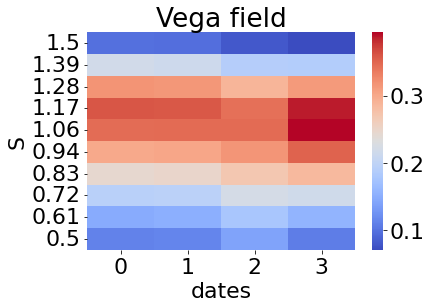

In [326]:
ax=plt.axes()
sns.heatmap(vega,cmap="coolwarm", xticklabels=np.flip(dates), yticklabels=np.flip(np.round(d1_stocks,2)), ax=ax)
ax.set_title("Vega field")
ax.set_xlabel("dates")
ax.set_ylabel("S")
plt.show()